# Anomaly: Gross Profit to asset ratio 

in this part, we will investigate the anomaly of Gross Profit to asset ratio. The reference of this part is [Novy-Marx, Robert, “The Other Side of Value: The Gross Profitability Premium,”](papers/❀The%20other%20side%20of%20value：The%20gross%20profitability%20premium.pdf) 

# 1. construct ratio factor

In [149]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from finance_byu import fama_macbeth
from numpy_ext import rolling_apply

In [150]:
# Load the data
data = pd.read_excel('source_data/利润表/FS_Comins.xlsx')

/home/msi/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [151]:
data.head(5)

,Stkcd,ShortName,Accper,Typrep,B001100000,B001200000
0,证券代码,证券简称,统计截止日期,报表类型,营业总收入,营业总成本
1,没有单位,没有单位,没有单位,没有单位,元,元
2,000001,深发展A,2000-01-01,A,1079657853,1070282071
3,000001,深发展A,2000-06-30,A,563942659,524513922
4,000001,深发展A,2000-12-31,A,1431286264,1259262034


In [152]:
data = data.iloc[2:, :]
data['B001100000'] = data['B001100000'].astype(float)
data['B001200000'] = data['B001200000'].astype(float)
data['gross profit'] = data['B001100000'] - data['B001200000']
data.head(5)

,Stkcd,ShortName,Accper,Typrep,B001100000,B001200000,gross profit
2,000001,深发展A,2000-01-01,A,1.079658e+09,1.070282e+09,9375782.0
3,000001,深发展A,2000-06-30,A,5.639427e+08,5.245139e+08,39428737.0
4,000001,深发展A,2000-12-31,A,1.431286e+09,1.259262e+09,172024230.0
5,000001,深发展A,2001-01-01,A,1.431286e+09,1.302838e+09,128448010.0
6,000001,深发展A,2001-06-30,A,8.365142e+08,7.680241e+08,68490081.0


In [153]:
data = data[data['Typrep'] == "A"]
data = data[["Stkcd", "Accper", "gross profit"]]
data.head()

,Stkcd,Accper,gross profit
2,000001,2000-01-01,9375782.0
3,000001,2000-06-30,39428737.0
4,000001,2000-12-31,172024230.0
5,000001,2001-01-01,128448010.0
6,000001,2001-06-30,68490081.0


In [154]:
data.columns = ['Stkcd', 'date', 'gross_profit']

In [155]:
data.head()

,Stkcd,date,gross_profit
2,000001,2000-01-01,9375782.0
3,000001,2000-06-30,39428737.0
4,000001,2000-12-31,172024230.0
5,000001,2001-01-01,128448010.0
6,000001,2001-06-30,68490081.0


In [156]:
# this procedure is the same in part1
balance_sheet = pd.read_csv(r'source_data/Balance Sheet/balance_sheet.csv')  # load the balance sheet data
balance_sheet = balance_sheet[balance_sheet['Statement Type'] == "A"]
balance_sheet = balance_sheet[['Stock Code', 'Ending Date of Statistics', 'Total Assets', 'Total Shareholders’ Equity']]
balance_sheet.columns = ['Stkcd', 'date', 'total_assets', 'total_shareholders_equity']
balance_sheet = balance_sheet.iloc[1:, :]
balance_sheet['date'] = pd.to_datetime(balance_sheet['date'])
balance_sheet['month'] = balance_sheet['date'].dt.to_period('M')
balance_sheet = balance_sheet[['Stkcd', 'month', 'total_assets', 'total_shareholders_equity']]
balance_sheet

/tmp/ipykernel_283013/409038487.py:2: DtypeWarning: Columns (1,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  balance_sheet = pd.read_csv(r'source_data/Balance Sheet/balance_sheet.csv')  # load the balance sheet data


,Stkcd,month,total_assets,total_shareholders_equity
2,000001,2000-06,49732336516,3078512556
3,000001,2000-12,67227499769,4738883655
4,000001,2001-01,66006167607,3517551493
5,000001,2001-06,85181426762,4961824149
6,000001,2001-12,120126983351,3627668792
...,...,...,...,...
583378,900957,2023-01,1066446596.43,566925821.84
583380,900957,2023-03,1070059261.75,575645952.6
583382,900957,2023-06,1067733802.62,586222511.87
583384,900957,2023-09,1060743496.42,598366406.44


In [157]:
# merge data and balance sheet
data['month'] = pd.to_datetime(data['date']).dt.to_period('M')
data = data.merge(balance_sheet, on=['Stkcd', 'month'], how='left')
data

,Stkcd,date,gross_profit,month,total_assets,total_shareholders_equity
0,000001,2000-01-01,9.375782e+06,2000-01,NaN,NaN
1,000001,2000-06-30,3.942874e+07,2000-06,49732336516,3078512556
2,000001,2000-12-31,1.720242e+08,2000-12,67227499769,4738883655
3,000001,2001-01-01,1.284480e+08,2001-01,66006167607,3517551493
4,000001,2001-06-30,6.849008e+07,2001-06,85181426762,4961824149
...,...,...,...,...,...,...
314441,900957,2023-01-01,3.559758e+07,2023-01,NaN,NaN
314442,900957,2023-03-31,9.810177e+06,2023-03,NaN,NaN
314443,900957,2023-06-30,2.004156e+07,2023-06,NaN,NaN
314444,900957,2023-09-30,3.071038e+07,2023-09,NaN,NaN


In [158]:
data['total_assets'] = data['total_assets'].astype(float)
data['gross_profit_to_asset'] = data['gross_profit'] / data['total_assets']
data.head()

,Stkcd,date,gross_profit,month,total_assets,total_shareholders_equity,gross_profit_to_asset
0,000001,2000-01-01,9375782.0,2000-01,NaN,NaN,NaN
1,000001,2000-06-30,39428737.0,2000-06,4.973234e+10,3078512556,0.000793
2,000001,2000-12-31,172024230.0,2000-12,6.722750e+10,4738883655,0.002559
3,000001,2001-01-01,128448010.0,2001-01,6.600617e+10,3517551493,0.001946
4,000001,2001-06-30,68490081.0,2001-06,8.518143e+10,4961824149,0.000804


In [159]:
monthly_stock_return = pd.read_feather('temp/monthly_stock_return.feather')
monthly_stock_return

,Stkcd,month,market_value,monthly_stock_return
2,000001,2000-01,28755726.61,0.061891
3,000001,2000-02,28429838.73,-0.011333
4,000001,2000-03,28507431.08,0.002729
5,000001,2000-04,29562687.10,0.037017
6,000001,2000-05,27933247.66,-0.055118
...,...,...,...,...
730496,900957,2023-09,139949.00,-0.067446
730497,900957,2023-10,139251.00,-0.004992
730498,900957,2023-11,144486.00,0.037596
730499,900957,2023-12,144137.00,-0.002418


In [160]:
monthly_stock_return.dtypes

Stkcd                      object
month                   period[M]
market_value              float64
monthly_stock_return      float64
dtype: object

In [161]:
monthly_stock_return = monthly_stock_return.merge(data[['Stkcd', 'month', 'gross_profit_to_asset']],
                                                  on=['Stkcd', 'month'], how='left').bfill()
monthly_stock_return

,Stkcd,month,market_value,monthly_stock_return,gross_profit_to_asset
0,000001,2000-01,28755726.61,0.061891,0.000793
1,000001,2000-02,28429838.73,-0.011333,0.000793
2,000001,2000-03,28507431.08,0.002729,0.000793
3,000001,2000-04,29562687.10,0.037017,0.000793
4,000001,2000-05,27933247.66,-0.055118,0.000793
...,...,...,...,...,...
730494,900957,2023-09,139949.00,-0.067446,NaN
730495,900957,2023-10,139251.00,-0.004992,NaN
730496,900957,2023-11,144486.00,0.037596,NaN
730497,900957,2023-12,144137.00,-0.002418,NaN


In [162]:
def ten_division(x):
    edge1, edge2, edge3, edge4, edge5, edge6, edge7, edge8, edge9 = x.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    return pd.Series([0.0 if i < edge1 else 1.0 if i < edge2 else 2.0 if i < edge3 else 3.0 if i < edge4 else 4.0 if i < edge5 else 5.0 if i < edge6 else 6.0 if i < edge7 else 7.0 if i < edge8 else 8.0 if i < edge9 else 9.0 for i in x], index=x.index)
    

monthly_stock_return = monthly_stock_return.dropna()
monthly_stock_return['GP/Assets_tag'] = monthly_stock_return.groupby(['month'])['gross_profit_to_asset'].transform(ten_division)
monthly_stock_return

/tmp/ipykernel_283013/1741013585.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return['GP/Assets_tag'] = monthly_stock_return.groupby(['month'])['gross_profit_to_asset'].transform(ten_division)


,Stkcd,month,market_value,monthly_stock_return,gross_profit_to_asset,GP/Assets_tag
0,000001,2000-01,28755726.61,0.061891,0.000793,2.0
1,000001,2000-02,28429838.73,-0.011333,0.000793,2.0
2,000001,2000-03,28507431.08,0.002729,0.000793,2.0
3,000001,2000-04,29562687.10,0.037017,0.000793,2.0
4,000001,2000-05,27933247.66,-0.055118,0.000793,2.0
...,...,...,...,...,...,...
86574,000783,2011-09,20914282.46,0.003413,0.014607,4.0
86575,000783,2011-10,22242173.41,0.063492,0.014719,4.0
86576,000783,2011-11,18614185.64,-0.163113,0.014719,4.0
86577,000783,2011-12,16954321.95,-0.089172,0.014719,4.0


In [163]:
# import and clean the risk-free rate data
rf = pd.read_excel('source_data/Risk-Free Rate/TRD_Nrrate.xlsx')  # load the risk-free rate data
rf = rf.iloc[2:, :]
rf = rf[['Clsdt', 'Nrrdaydt', 'Nrrdata']]
rf.columns = ['date', 'daily_rf', 'rf']
rf['date'] = pd.to_datetime(rf['date'])
rf['daily_rf'] = rf['daily_rf'] / 100  # change the unit of the risk-free rate to decimal
rf['rf'] = rf['rf'] / 100  # change the unit of the risk-free rate to decimal
rf['month'] = rf['date'].dt.to_period('M')
rf_monthly = rf.groupby('month').agg({'daily_rf': [lambda x: (1 + x).prod() - 1], 'rf': 'last'})
rf_monthly.reset_index(inplace=True)
rf_monthly.columns = ['month', 'monthly_rf', 'rf']

# merge the risk-free rate data into monthly_stock_return
monthly_stock_return['rf'] = monthly_stock_return['month'].map(rf_monthly.set_index('month')['monthly_rf'])

/home/msi/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/tmp/ipykernel_283013/3362012092.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return['rf'] = monthly_stock_return['month'].map(rf_monthly.set_index('month')['monthly_rf'])


In [164]:
monthly_stock_return['excess_return'] = monthly_stock_return['monthly_stock_return'] - monthly_stock_return['rf']

/tmp/ipykernel_283013/2378013268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return['excess_return'] = monthly_stock_return['monthly_stock_return'] - monthly_stock_return['rf']


In [165]:
vw_group = monthly_stock_return.groupby(['month', 'GP/Assets_tag'], observed=False).apply(
    lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_group = vw_group.reset_index()
vw_group['9 - 0'] = vw_group[9] - vw_group[0]

ew_group = monthly_stock_return.groupby(['month', 'GP/Assets_tag'], observed=False)['excess_return'].mean().unstack()
ew_group = ew_group.reset_index()
ew_group['9 - 0'] = ew_group[9] - ew_group[0]
ew_group

GP/Assets_tag,month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,9 - 0
0,2000-01,0.025264,0.074104,0.163821,0.137538,0.195758,0.167055,0.142019,0.154009,0.223832,0.184372,0.159109
1,2000-02,0.151682,0.175988,0.133681,0.134919,0.156823,0.133863,0.165835,0.172363,0.121170,0.084669,-0.067012
2,2000-03,0.200701,0.159007,0.115812,0.119012,0.086736,0.094692,0.123790,0.051767,0.063647,0.143851,-0.056850
3,2000-04,-0.007980,-0.004877,0.013227,-0.019040,0.028792,-0.004608,0.037414,0.010979,0.012676,0.050757,0.058737
4,2000-05,0.005894,0.057223,0.032928,0.019074,0.056879,0.025811,0.032350,0.040034,0.023077,0.080215,0.074321
...,...,...,...,...,...,...,...,...,...,...,...,...
284,2023-09,0.035331,-0.006042,-0.015941,-0.013188,-0.003258,0.007966,0.008422,-0.001523,-0.008780,-0.006339,-0.041670
285,2023-10,-0.044218,-0.005710,-0.003407,-0.017112,-0.018446,0.012065,-0.017161,0.013521,-0.005855,-0.021772,0.022446
286,2023-11,0.067652,0.049274,0.040990,0.023543,0.014593,0.030067,0.021119,0.013325,0.015821,0.002751,-0.064902
287,2023-12,-0.045219,-0.048395,-0.024064,-0.041233,-0.036213,-0.034909,-0.026813,-0.021946,0.009860,-0.028778,0.016441


In [166]:
stats_list = ['mean', 'var', 'min', 'max', 'std',
              lambda x: x.quantile(.25), lambda x: x.quantile(.5),
              lambda x: x.quantile(.75), 'skew', lambda
                  x: x.kurt()]

# value-weighted
vw_result = vw_group.agg({0: stats_list, 1: stats_list, 2: stats_list, 3: stats_list, 4: stats_list,
                          5: stats_list, 6: stats_list, 7: stats_list, 8: stats_list, 9: stats_list, '9 - 0':stats_list})
vw_result.index = ['mean', 'var', 'min', 'max', 'std', '25%', '50%', '75%', 'skew', 'kurt']
vw_result

GP/Assets_tag,0,1,2,3,4,5,6,7,8,9,9 - 0
mean,0.012791,0.013499,0.012133,0.013022,0.012270,0.014896,0.029303,0.018264,0.023106,0.031236,0.018445
var,0.012618,0.011204,0.008978,0.008741,0.010011,0.012663,0.028789,0.008868,0.010602,0.010189,0.010744
min,-0.312998,-0.295936,-0.304302,-0.263064,-0.256128,-0.269074,-0.290756,-0.331451,-0.310298,-0.232805,-0.210186
max,0.340743,0.408187,0.331057,0.328500,0.563742,1.107387,2.208695,0.335790,0.676209,0.743072,0.889282
std,0.112330,0.105850,0.094755,0.093491,0.100053,0.112529,0.169674,0.094170,0.102968,0.100939,0.103653
25%,-0.053067,-0.045460,-0.046781,-0.044082,-0.051442,-0.046413,-0.043372,-0.037769,-0.035651,-0.027767,-0.031735
50%,0.006708,0.008691,0.008969,0.005961,0.005733,0.006050,0.009373,0.013828,0.011118,0.024550,0.009234
75%,0.074850,0.062595,0.062042,0.059349,0.063555,0.065902,0.066646,0.060339,0.070469,0.081545,0.061505
skew,0.223243,0.528019,0.249755,0.227575,0.851063,3.344790,7.908710,0.049385,1.163182,2.222371,2.953367
kurt,0.569069,1.958620,1.007577,0.956844,3.636197,30.294404,95.961232,1.371562,6.096663,14.791042,20.735349


In [167]:
# equal-weighted
ew_result = ew_group.agg({0: stats_list, 1: stats_list, 2: stats_list, 3: stats_list, 4: stats_list,
                            5: stats_list, 6: stats_list, 7: stats_list, 8: stats_list, 9: stats_list, '9 - 0':stats_list})
ew_result.index = ['mean', 'var', 'min', 'max', 'std', '25%', '50%', '75%', 'skew', 'kurt']
ew_result

GP/Assets_tag,0,1,2,3,4,5,6,7,8,9,9 - 0
mean,0.006824,0.007831,0.009033,0.007479,0.007956,0.009055,0.013625,0.014120,0.018734,0.024498,0.017674
var,0.012775,0.010991,0.010269,0.009313,0.009064,0.008831,0.009186,0.008762,0.009828,0.010191,0.007044
min,-0.304891,-0.305499,-0.295974,-0.301732,-0.317510,-0.275797,-0.278625,-0.335562,-0.310874,-0.265863,-0.219637
max,0.355813,0.351550,0.447874,0.376349,0.376477,0.369306,0.444006,0.362473,0.436318,0.821806,0.692953
std,0.113027,0.104839,0.101334,0.096503,0.095207,0.093973,0.095845,0.093605,0.099136,0.100951,0.083929
25%,-0.057575,-0.053711,-0.051802,-0.048582,-0.049360,-0.044055,-0.041150,-0.041626,-0.036805,-0.029374,-0.030478
50%,0.000994,0.001009,0.001510,0.002537,0.003115,0.005835,0.005524,0.010404,0.010069,0.014519,0.010915
75%,0.068160,0.061697,0.060739,0.058789,0.060933,0.056230,0.057445,0.058918,0.059674,0.066868,0.058737
skew,0.282879,0.290262,0.360915,0.172253,0.199697,0.291165,0.557390,0.314978,0.656604,2.146779,2.054533
kurt,0.764055,1.084105,1.916639,1.267144,1.348534,1.163149,2.433889,1.831880,2.374468,15.324958,14.336008


from sheets above, we can find that the value-weighted and equal-weighted returns of the 9th group are higher than the 0th group. This means that the Gross Profit to asset ratio has a positive relationship with the stock return.

# 2. check the correlation of ratio factor with FF 5

In this part, we will check the correlation of the Gross Profit to asset ratio with the Fama-French 5 factors.

In [168]:
factor_data = pd.read_excel(
    'source_data/5-Factor Model Index (Monthly)/STK_MKT_FIVEFACMONTH.xlsx')
factor_data = factor_data[
    ['MarkettypeID', 'TradingMonth', 'Portfolios', 'RiskPremium2', 'SMB2', 'HML2', 'RMW2', 'CMA2']]
factor_data.columns = ['MarkettypeID', 'date', 'portfolios', 'risk_premium', 'smb', 'hml', 'rmw', 'cma']
factor_data = factor_data.iloc[2:, :]
factor_data = factor_data[factor_data['portfolios'] == 1]
factor_data = factor_data[
    factor_data['MarkettypeID'] == "P9706"]  # P9706: SSE-SZSE A share market (excluding STAR Market, ChiNext)
factor_data.reset_index(drop=True, inplace=True)  # reset the index to 0,1,2,...
factor_data['date'] = pd.to_datetime(factor_data['date']).dt.to_period('M')
factor_data = factor_data[['date', 'risk_premium', 'smb', 'hml', 'rmw', 'cma']]
factor_data.columns = ['month', 'risk_premium', 'SMB', 'HML', 'RMW', 'CMA']
factor_data.head(5)

/home/msi/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,month,risk_premium,SMB,HML,RMW,CMA
0,2000-01,0.135225,-0.005175,-0.104151,0.042289,-0.076779
1,2000-02,0.113951,0.032327,-0.002393,-0.011365,0.03855
2,2000-03,0.058133,0.069624,0.01608,-0.051447,0.065904
3,2000-04,0.015578,-0.010779,0.02358,-0.022984,0.00972
4,2000-05,0.027197,0.025777,0.025355,-0.00662,-0.005409


In [169]:
factor_data = factor_data.merge(vw_group[['month', '9 - 0']], on='month', how='left')
factor_data = factor_data.rename(columns={'9 - 0': 'vw_GP/Assets'})
factor_data = factor_data.merge(ew_group[['month', '9 - 0']], on='month', how='left')
factor_data = factor_data.rename(columns={'9 - 0': 'ew_GP/Assets'})
factor_data

,month,risk_premium,SMB,HML,RMW,CMA,vw_GP/Assets,ew_GP/Assets
0,2000-01,0.135225,-0.005175,-0.104151,0.042289,-0.076779,0.235983,0.159109
1,2000-02,0.113951,0.032327,-0.002393,-0.011365,0.03855,-0.072123,-0.067012
2,2000-03,0.058133,0.069624,0.01608,-0.051447,0.065904,-0.117221,-0.056850
3,2000-04,0.015578,-0.010779,0.02358,-0.022984,0.00972,0.069270,0.058737
4,2000-05,0.027197,0.025777,0.025355,-0.00662,-0.005409,0.057835,0.074321
...,...,...,...,...,...,...,...,...
284,2023-09,-0.002334,0.0091,0.015482,-0.00497,-0.003365,-0.125172,-0.041670
285,2023-10,-0.02938,0.026882,-0.009619,-0.016592,-0.003727,0.034824,0.022446
286,2023-11,-0.00157,0.052495,-0.008304,-0.021795,0.019977,-0.094913,-0.064902
287,2023-12,-0.015435,0.005892,0.002136,0.019856,-0.014981,0.003117,0.016441


In [170]:
factor_data['risk_premium'] = factor_data['risk_premium'].astype(float)
factor_data['SMB'] = factor_data['SMB'].astype(float)
factor_data['HML'] = factor_data['HML'].astype(float)
factor_data['RMW'] = factor_data['RMW'].astype(float)
factor_data['CMA'] = factor_data['CMA'].astype(float)

## 2.1 Correlation

In [171]:
factor_data[['risk_premium', 'SMB', 'HML', 'RMW', 'CMA', 'vw_GP/Assets', 'ew_GP/Assets']].corr()

,risk_premium,SMB,HML,RMW,CMA,vw_GP/Assets,ew_GP/Assets
risk_premium,1.000000,0.095291,-0.137413,-0.252714,0.103738,-0.192766,-0.056582
SMB,0.095291,1.000000,-0.534818,-0.732352,0.435422,-0.498419,-0.490759
HML,-0.137413,-0.534818,1.000000,0.260956,0.109132,0.149286,0.185590
RMW,-0.252714,-0.732352,0.260956,1.000000,-0.708683,0.567110,0.546922
CMA,0.103738,0.435422,0.109132,-0.708683,1.000000,-0.427776,-0.440295
vw_GP/Assets,-0.192766,-0.498419,0.149286,0.567110,-0.427776,1.000000,0.811213
ew_GP/Assets,-0.056582,-0.490759,0.185590,0.546922,-0.440295,0.811213,1.000000


In [172]:
factor_data[['risk_premium', 'SMB', 'HML', 'RMW', 'CMA', 'vw_GP/Assets', 'ew_GP/Assets']].corr('spearman')

,risk_premium,SMB,HML,RMW,CMA,vw_GP/Assets,ew_GP/Assets
risk_premium,1.000000,0.175743,-0.162226,-0.292515,0.114944,-0.238469,-0.150871
SMB,0.175743,1.000000,-0.494069,-0.692073,0.435525,-0.574681,-0.526662
HML,-0.162226,-0.494069,1.000000,0.259921,0.060710,0.222973,0.215654
RMW,-0.292515,-0.692073,0.259921,1.000000,-0.690923,0.675669,0.608798
CMA,0.114944,0.435525,0.060710,-0.690923,1.000000,-0.498026,-0.489688
vw_GP/Assets,-0.238469,-0.574681,0.222973,0.675669,-0.498026,1.000000,0.847070
ew_GP/Assets,-0.150871,-0.526662,0.215654,0.608798,-0.489688,0.847070,1.000000


## 2.2 Regression

In [173]:
Y = factor_data['vw_GP/Assets']
X = factor_data[['risk_premium', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vw_GP/Assets   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     30.49
Date:                Mon, 24 Jun 2024   Prob (F-statistic):           8.89e-25
Time:                        16:15:59   Log-Likelihood:                 307.78
No. Observations:                 289   AIC:                            -603.6
Df Residuals:                     283   BIC:                            -581.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0242      0.005      4.714      0.000       0.014       0.034
risk_premium    -0.1303      0.073     -1.775      0.077      -0.275       0.014
SMB             -0.6270      0.195     -3.218      0.001      -1.011      -0.244
HML             -0.2724      0.201     -1.352      0.177      -0.669       0.124
RMW              1.0907      0.320      3.407      0.001       0.461       1.721
CMA             -0.2653      0.335     -0.793      0.429      -0.924       0.394
==============================================================================
Omnibus:                      327.495   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21709.879
Skew:                           4.736   Prob(JB):                         0.00
Kurtosis:                      44.391   Cond. No.                         85.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
Y = factor_data['ew_GP/Assets']
X = factor_data[['risk_premium', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ew_GP/Assets   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     27.85
Date:                Mon, 24 Jun 2024   Prob (F-statistic):           6.34e-23
Time:                        16:15:59   Log-Likelihood:                 364.33
No. Observations:                 289   AIC:                            -716.7
Df Residuals:                     283   BIC:                            -694.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0205      0.004      4.860      0.000       0.012       0.029
risk_premium     0.0693      0.060      1.149      0.252      -0.049       0.188
SMB             -0.3542      0.160     -2.211      0.028      -0.670      -0.039
HML              0.0661      0.166      0.399      0.690      -0.260       0.392
RMW              0.8526      0.263      3.239      0.001       0.334       1.371
CMA             -0.5162      0.275     -1.875      0.062      -1.058       0.026
==============================================================================
Omnibus:                      236.282   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7860.101
Skew:                           2.958   Prob(JB):                         0.00
Kurtosis:                      27.854   Cond. No.                         85.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

from the regression results above, we can find that the Gross Profit to asset ratio has relationship with SMB and RMW.

And since R-squared is very low, we can conclude that the Gross Profit is a new factor different from FF5.

# 3. Fama-macbeth regression on FF5 and Gross Profit to asset ratio

we will run two Fama-macbeth regression：on FF5, and FF5 with Gross Profit to asset ratio. We want to know:
1. whether the Gross Profit to asset ratio is a new factor by comparing  whether the coefficient of Gross Profit to asset ratio is significant.
2. whether the Gross Profit to asset ratio can explain the cross-section stock return better by comparing the R-squared of the two regressions and the alpha of the two regressions.

It should be pointed out that, in this part, we use portfolio level while in part 2 we use stock level. 

Moreover, we use rolling regression with window=12 to calculate the factor loading, while in part 2 we use the definition of $\beta: \frac{cov}{var}$ to get loading

In [175]:
monthly_stock_return

,Stkcd,month,market_value,monthly_stock_return,gross_profit_to_asset,GP/Assets_tag,rf,excess_return
0,000001,2000-01,28755726.61,0.061891,0.000793,2.0,0.001893,0.059998
1,000001,2000-02,28429838.73,-0.011333,0.000793,2.0,0.001771,-0.013104
2,000001,2000-03,28507431.08,0.002729,0.000793,2.0,0.001893,0.000836
3,000001,2000-04,29562687.10,0.037017,0.000793,2.0,0.001832,0.035185
4,000001,2000-05,27933247.66,-0.055118,0.000793,2.0,0.001893,-0.057011
...,...,...,...,...,...,...,...,...
86574,000783,2011-09,20914282.46,0.003413,0.014607,4.0,0.002824,0.000589
86575,000783,2011-10,22242173.41,0.063492,0.014719,4.0,0.002918,0.060574
86576,000783,2011-11,18614185.64,-0.163113,0.014719,4.0,0.002824,-0.165937
86577,000783,2011-12,16954321.95,-0.089172,0.014719,4.0,0.002918,-0.092090


In [176]:
monthly_stock_return['mkt_risk_premium'] = monthly_stock_return['month'].map(factor_data.set_index('month')['risk_premium'])
monthly_stock_return['SMB'] = monthly_stock_return['month'].map(factor_data.set_index('month')['SMB'])
monthly_stock_return['HML'] = monthly_stock_return['month'].map(factor_data.set_index('month')['HML'])
monthly_stock_return['RMW'] = monthly_stock_return['month'].map(factor_data.set_index('month')['RMW'])
monthly_stock_return['CMA'] = monthly_stock_return['month'].map(factor_data.set_index('month')['CMA'])

/tmp/ipykernel_283013/1475819546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return['mkt_risk_premium'] = monthly_stock_return['month'].map(factor_data.set_index('month')['risk_premium'])
/tmp/ipykernel_283013/1475819546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return['SMB'] = monthly_stock_return['month'].map(factor_data.set_index('month')['SMB'])
/tmp/ipykernel_283013/1475819546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [177]:
def simple_reg(y, x1, x2, x3, x4, x5):
    x = sm.add_constant(pd.DataFrame([x1, x2, x3, x4, x5]).T)
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model.params

In [178]:
tmp1 = monthly_stock_return.groupby(['month', 'GP/Assets_tag'], observed=False)['excess_return'].mean().reset_index()
tmp1 = tmp1.merge(factor_data, on='month', how='left')
tmp2 = tmp1.groupby(['GP/Assets_tag']).apply(lambda x: rolling_apply(simple_reg, 12,x['excess_return'], x['risk_premium'], x['SMB'], x['HML'], x['RMW'], x['CMA']))
tmp3 = tmp2[0]
tmp3 = pd.DataFrame(tmp3)
tmp3.columns = ['intercept', 'risk_premium_loading', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading']
tmp3['GP/Assets_tag'] = 0
tmp3['month'] = factor_data['month']

for i in range(1, 10):
    tmp4 = tmp2[i]
    tmp4 = pd.DataFrame(tmp4)
    tmp4.columns = ['intercept', 'risk_premium_loading', 'SMB_loading', 'HML_Loading', 'RMW_loading', 'CMA_loading']
    tmp4['GP/Assets_tag'] = i
    tmp4['month'] = factor_data['month']
    tmp3 = pd.concat([tmp3,tmp4])

tmp1 = tmp1.merge(tmp3, on=['month', 'GP/Assets_tag'], how='left')
# monthly_stock_return.drop(columns=['mkt_loading', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading'])

/tmp/ipykernel_283013/2525015343.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp2 = tmp1.groupby(['GP/Assets_tag']).apply(lambda x: rolling_apply(simple_reg, 12,x['excess_return'], x['risk_premium'], x['SMB'], x['HML'], x['RMW'], x['CMA']))


In [179]:
tmp1

,month,GP/Assets_tag,excess_return,risk_premium,SMB,HML,RMW,CMA,vw_GP/Assets,ew_GP/Assets,intercept,risk_premium_loading,SMB_loading,HML_loading,RMW_loading,CMA_loading,HML_Loading
0,2000-01,0.0,0.025264,0.135225,-0.005175,-0.104151,0.042289,-0.076779,0.235983,0.159109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,1.0,0.074104,0.135225,-0.005175,-0.104151,0.042289,-0.076779,0.235983,0.159109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,2.0,0.163821,0.135225,-0.005175,-0.104151,0.042289,-0.076779,0.235983,0.159109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01,3.0,0.137538,0.135225,-0.005175,-0.104151,0.042289,-0.076779,0.235983,0.159109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01,4.0,0.195758,0.135225,-0.005175,-0.104151,0.042289,-0.076779,0.235983,0.159109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,2024-01,5.0,-0.098389,-0.057066,-0.108162,0.108981,-0.003561,-0.007933,0.084720,-0.024187,0.006793,1.503850,0.431542,NaN,-1.612560,-0.868572,0.112090
2886,2024-01,6.0,-0.116874,-0.057066,-0.108162,0.108981,-0.003561,-0.007933,0.084720,-0.024187,-0.000164,1.059189,0.518965,NaN,-0.782316,-0.162679,0.000445
2887,2024-01,7.0,-0.137894,-0.057066,-0.108162,0.108981,-0.003561,-0.007933,0.084720,-0.024187,-0.012949,0.829232,0.983563,NaN,0.199000,0.461100,0.406112
2888,2024-01,8.0,-0.107867,-0.057066,-0.108162,0.108981,-0.003561,-0.007933,0.084720,-0.024187,0.006201,1.234217,0.028700,NaN,-0.161261,-0.161208,-0.396224


In [180]:
tmp1['t+1_excess_return'] = tmp1.groupby("GP/Assets_tag")['excess_return'].shift(-1)

In [181]:
ff5_result = fama_macbeth.fm_summary(fama_macbeth.fama_macbeth(tmp1[['month', 't+1_excess_return', 'risk_premium_loading', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading']].dropna(),'month', 't+1_excess_return', ['risk_premium_loading', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading']), pvalues=True)
ff5_result

,mean,std_error,tstat,pval
intercept,0.000273,0.001243,0.219594,0.826350
risk_premium_loading,-0.000077,0.001252,-0.061520,0.950990
SMB_loading,0.000345,0.001075,0.320767,0.748629
HML_loading,0.000602,0.000807,0.745503,0.456602
RMW_loading,-0.000342,0.001246,-0.274982,0.783536
CMA_loading,0.000306,0.001094,0.279432,0.780122


In [182]:
ff5_result.to_excel('output/part3/3. ff5_result_equal_weighted.xlsx')

In [183]:
tmp1 = monthly_stock_return.groupby(['month', 'GP/Assets_tag'], observed=False)['excess_return'].mean().reset_index()
tmp1 = tmp1.merge(factor_data, on='month', how='left')
tmp1 = tmp1.dropna()
tmp2 = tmp1.groupby(['GP/Assets_tag']).apply(lambda x: rolling_apply(simple_reg, 12,x['excess_return'], x['risk_premium'], x['SMB'], x['HML'], x['RMW'], x['CMA']))
tmp3 = tmp2[0]
tmp3 = pd.DataFrame(tmp3)
tmp3.columns = ['intercept', 'risk_premium_loading', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading']
tmp3['GP/Assets_tag'] = 0
tmp3['month'] = factor_data['month']

for i in range(1, 10):
    tmp4 = tmp2[i]
    tmp4 = pd.DataFrame(tmp4)
    tmp4.columns = ['intercept', 'risk_premium_loading', 'SMB_loading', 'HML_Loading', 'RMW_loading', 'CMA_loading']
    tmp4['GP/Assets_tag'] = i
    tmp4['month'] = factor_data['month']
    tmp3 = pd.concat([tmp3,tmp4])

tmp1 = tmp1.merge(tmp3, on=['month', 'GP/Assets_tag'], how='left')

/tmp/ipykernel_283013/1191556088.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp2 = tmp1.groupby(['GP/Assets_tag']).apply(lambda x: rolling_apply(simple_reg, 12,x['excess_return'], x['risk_premium'], x['SMB'], x['HML'], x['RMW'], x['CMA']))


In [184]:
tmp1['t+1_excess_return'] = tmp1.groupby("GP/Assets_tag")['excess_return'].shift(-1)

In [185]:
ff5_vw_result = fama_macbeth.fm_summary(fama_macbeth.fama_macbeth(tmp1[['month', 't+1_excess_return', 'risk_premium_loading', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading']].replace([np.inf, -np.inf], np.nan).dropna(),'month', 't+1_excess_return', ['risk_premium_loading', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading']), pvalues=True)
ff5_vw_result

,mean,std_error,tstat,pval
intercept,0.000273,0.001243,0.219594,0.826350
risk_premium_loading,-0.000077,0.001252,-0.061520,0.950990
SMB_loading,0.000345,0.001075,0.320767,0.748629
HML_loading,0.000602,0.000807,0.745503,0.456602
RMW_loading,-0.000342,0.001246,-0.274982,0.783536
CMA_loading,0.000306,0.001094,0.279432,0.780122


In [186]:
ff5_vw_result.to_excel('output/part3/3. ff5_value_weighted.xlsx')

# 4. Using different model to explain the abnormal return of each group of Gross Profit to asset ratio

the target of this part is to find the alpha of group 0-9 using different models. And if different groups show different alpha, it means that the Gross Profit to asset ratio is indeed a new factor.

the output is similar to what teacher had in her ppt "part 3 page 16”, which is shown below:

![pic1.png](img/pic1.png)

In [187]:
vw_reg = vw_group.merge(factor_data, on='month', how='left')
ew_reg = ew_group.merge(factor_data, on='month', how='left')
vw_reg

,month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,9 - 0,risk_premium,SMB,HML,RMW,CMA,vw_GP/Assets,ew_GP/Assets
0,2000-01,0.041487,0.110694,0.148717,0.125170,0.363679,0.153833,0.140541,0.176434,0.250842,0.277470,0.235983,0.135225,-0.005175,-0.104151,0.042289,-0.076779,0.235983,0.159109
1,2000-02,0.153813,0.187468,0.117026,0.123145,0.118053,0.203588,0.163152,0.225821,0.127111,0.081690,-0.072123,0.113951,0.032327,-0.002393,-0.011365,0.038550,-0.072123,-0.067012
2,2000-03,0.202511,0.163047,0.113997,0.172959,0.066662,0.050036,0.152983,0.030400,0.046828,0.085290,-0.117221,0.058133,0.069624,0.016080,-0.051447,0.065904,-0.117221,-0.056850
3,2000-04,0.013512,0.031477,0.041104,-0.023696,0.041892,-0.003396,0.093339,0.023434,0.014600,0.082781,0.069270,0.015578,-0.010779,0.023580,-0.022984,0.009720,0.069270,0.058737
4,2000-05,0.009731,0.054129,0.028487,0.005961,0.028434,0.013256,0.018814,0.029398,0.025569,0.067565,0.057835,0.027197,0.025777,0.025355,-0.006620,-0.005409,0.057835,0.074321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,2023-09,0.101997,0.026328,-0.029116,-0.015081,-0.012543,0.001355,0.006329,0.010015,-0.022057,-0.023175,-0.125172,-0.002334,0.009100,0.015482,-0.004970,-0.003365,-0.125172,-0.041670
285,2023-10,-0.062518,0.025112,0.011185,-0.006387,-0.037909,-0.037184,0.030495,0.015152,-0.058281,-0.027694,0.034824,-0.029380,0.026882,-0.009619,-0.016592,-0.003727,0.034824,0.022446
286,2023-11,0.075801,0.049967,0.023348,0.001954,0.006055,0.002276,0.143030,0.020740,0.004080,-0.019112,-0.094913,-0.001570,0.052495,-0.008304,-0.021795,0.019977,-0.094913,-0.064902
287,2023-12,-0.032073,-0.060699,-0.035270,-0.023570,-0.023403,-0.043053,-0.067343,-0.032802,0.012956,-0.028956,0.003117,-0.015435,0.005892,0.002136,0.019856,-0.014981,0.003117,0.016441


In [188]:
def get_a_panel(x):
    result = pd.DataFrame([[0,]*11]*6, columns=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q10-Q1'], index=['CAPM','t-CAPM', 'FF3', 't-FF3', 'FF5', 't-FF5'], dtype=float)
    
    for i in range(10):
        temp = x[[i, 'risk_premium', 'SMB', 'HML', 'RMW', 'CMA']]
        Y = temp[i]
        X = temp[['risk_premium']]
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        result.iloc[0,i] = model.params.iloc[0]
        result.iloc[1,i] = model.tvalues.iloc[0]
        
        X = temp[['risk_premium', 'SMB', 'HML']]
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        result.iloc[2,i] = model.params.iloc[0]
        result.iloc[3,i] = model.tvalues.iloc[0]
        
        X = temp[['risk_premium', 'SMB', 'HML', 'RMW', 'CMA']]
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        result.iloc[4,i] = model.params.iloc[0]
        result.iloc[5,i] = model.tvalues.iloc[0]
    
    Y = x[9] - x[0]
    X = temp[['risk_premium']]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    result.iloc[0,10] = model.params.iloc[0]
    result.iloc[1,10] = model.tvalues.iloc[0]
    
    X = temp[['risk_premium', 'SMB', 'HML']]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    result.iloc[2,10] = model.params.iloc[0]
    result.iloc[3,10] = model.tvalues.iloc[0]
    
    X = temp[['risk_premium', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    result.iloc[4,10] = model.params.iloc[0]
    result.iloc[5,10] = model.tvalues.iloc[0]
    return result

vw_panel = get_a_panel(vw_reg)
ew_panel = get_a_panel(ew_reg)

In [189]:
vw_panel.to_excel('output/part3/4. vw_panel.xlsx')
ew_panel.to_excel('output/part3/4. ew_panel.xlsx')

# 5. Calculating alpha of long-short strategy

In [190]:
out_of_sample_month = monthly_stock_return[monthly_stock_return['month'] >= '2010-01']
monthly_stock_return = monthly_stock_return[monthly_stock_return['month'] <= '2009-12']

in this part, we want to conclude a similar table in teacher's PPT "part 3 page 14", which is shown below

![pic2.png](img/pic2.png)

## 5.1 add tag

In [191]:
monthly_stock_return

,Stkcd,month,market_value,monthly_stock_return,gross_profit_to_asset,GP/Assets_tag,rf,excess_return,mkt_risk_premium,SMB,HML,RMW,CMA
0,000001,2000-01,28755726.61,0.061891,0.000793,2.0,0.001893,0.059998,0.135225,-0.005175,-0.104151,0.042289,-0.076779
1,000001,2000-02,28429838.73,-0.011333,0.000793,2.0,0.001771,-0.013104,0.113951,0.032327,-0.002393,-0.011365,0.038550
2,000001,2000-03,28507431.08,0.002729,0.000793,2.0,0.001893,0.000836,0.058133,0.069624,0.016080,-0.051447,0.065904
3,000001,2000-04,29562687.10,0.037017,0.000793,2.0,0.001832,0.035185,0.015578,-0.010779,0.023580,-0.022984,0.009720
4,000001,2000-05,27933247.66,-0.055118,0.000793,2.0,0.001893,-0.057011,0.027197,0.025777,0.025355,-0.006620,-0.005409
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86549,000783,2009-08,28823308.00,-0.356636,0.031308,7.0,0.001893,-0.358529,-0.216761,0.054083,-0.024045,-0.010473,0.004303
86550,000783,2009-09,28287372.00,-0.018594,0.031308,7.0,0.001832,-0.020426,0.046157,-0.001580,-0.013148,0.021214,-0.015480
86551,000783,2009-10,31402500.00,0.110124,0.029513,6.0,0.001893,0.108231,0.078970,0.029394,-0.005362,-0.027737,0.018730
86552,000783,2009-11,39646729.90,0.160117,0.029513,6.0,0.001832,0.158285,0.068647,0.071150,-0.015642,-0.020761,0.033009


In [192]:
# we use average level as the indicator of GP/Assets tag
monthly_stock_return.loc[:,'past3_GP/Assets'] = monthly_stock_return.groupby('Stkcd')['gross_profit_to_asset'].rolling(3).mean().values
monthly_stock_return.loc[:,'past6_GP/Assets'] = monthly_stock_return.groupby('Stkcd')['gross_profit_to_asset'].rolling(6).mean().values
monthly_stock_return.loc[:, "past9_GP/Assets"] = monthly_stock_return.groupby('Stkcd')['gross_profit_to_asset'].rolling(9).mean().values
monthly_stock_return.loc[:, "past12_GP/Assets"] = monthly_stock_return.groupby('Stkcd')['gross_profit_to_asset'].rolling(12).mean().values

monthly_stock_return.loc[:,'past3_GP/Assets'] = monthly_stock_return.groupby('Stkcd')['past3_GP/Assets'].shift(1)
monthly_stock_return.loc[:,'past6_GP/Assets'] = monthly_stock_return.groupby('Stkcd')['past6_GP/Assets'].shift(1)
monthly_stock_return.loc[:,'past9_GP/Assets'] = monthly_stock_return.groupby('Stkcd')['past9_GP/Assets'].shift(1)
monthly_stock_return.loc[:,'past12_GP/Assets'] = monthly_stock_return.groupby('Stkcd')['past12_GP/Assets'].shift(1)

/tmp/ipykernel_283013/3273765225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return.loc[:,'past3_GP/Assets'] = monthly_stock_return.groupby('Stkcd')['gross_profit_to_asset'].rolling(3).mean().values
/tmp/ipykernel_283013/3273765225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return.loc[:,'past6_GP/Assets'] = monthly_stock_return.groupby('Stkcd')['gross_profit_to_asset'].rolling(6).mean().values
/tmp/ipykernel_283013/3273765225.py:4: SettingWithCopyWarning: 
A valu

In [193]:
monthly_stock_return.tail()

,Stkcd,month,market_value,monthly_stock_return,gross_profit_to_asset,GP/Assets_tag,rf,excess_return,mkt_risk_premium,SMB,HML,RMW,CMA,past3_GP/Assets,past6_GP/Assets,past9_GP/Assets,past12_GP/Assets
86549,000783,2009-08,28823308.00,-0.356636,0.031308,7.0,0.001893,-0.358529,-0.216761,0.054083,-0.024045,-0.010473,0.004303,0.028727,0.021942,0.021337,0.021526
86550,000783,2009-09,28287372.00,-0.018594,0.031308,7.0,0.001832,-0.020426,0.046157,-0.001580,-0.013148,0.021214,-0.015480,0.030017,0.025657,0.022580,0.022212
86551,000783,2009-10,31402500.00,0.110124,0.029513,6.0,0.001893,0.108231,0.078970,0.029394,-0.005362,-0.027737,0.018730,0.031308,0.029372,0.023822,0.022898
86552,000783,2009-11,39646729.90,0.160117,0.029513,6.0,0.001832,0.158285,0.068647,0.071150,-0.015642,-0.020761,0.033009,0.030709,0.029718,0.024865,0.023680
86553,000783,2009-12,41883100.75,0.056407,0.029513,6.0,0.001893,0.054514,0.024555,0.008614,0.021187,-0.010495,0.008448,0.030111,0.030064,0.027142,0.024463


In [194]:
monthly_stock_return['past3_GP/Assets_tag'] = monthly_stock_return.groupby('month')['past3_GP/Assets'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
monthly_stock_return['past6_GP/Assets_tag'] = monthly_stock_return.groupby('month')['past6_GP/Assets'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
monthly_stock_return['past9_GP/Assets_tag'] = monthly_stock_return.groupby('month')['past9_GP/Assets'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
monthly_stock_return['past12_GP/Assets_tag'] = monthly_stock_return.groupby('month')['past12_GP/Assets'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
monthly_stock_return

/tmp/ipykernel_283013/1783529018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return['past3_GP/Assets_tag'] = monthly_stock_return.groupby('month')['past3_GP/Assets'].transform(
/tmp/ipykernel_283013/1783529018.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return['past6_GP/Assets_tag'] = monthly_stock_return.groupby('month')['past6_GP/Assets'].transform(
/tmp/ipykernel_283013/1783529018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,Stkcd,month,market_value,monthly_stock_return,gross_profit_to_asset,GP/Assets_tag,rf,excess_return,mkt_risk_premium,SMB,...,RMW,CMA,past3_GP/Assets,past6_GP/Assets,past9_GP/Assets,past12_GP/Assets,past3_GP/Assets_tag,past6_GP/Assets_tag,past9_GP/Assets_tag,past12_GP/Assets_tag
0,000001,2000-01,28755726.61,0.061891,0.000793,2.0,0.001893,0.059998,0.135225,-0.005175,...,0.042289,-0.076779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000001,2000-02,28429838.73,-0.011333,0.000793,2.0,0.001771,-0.013104,0.113951,0.032327,...,-0.011365,0.038550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2000-03,28507431.08,0.002729,0.000793,2.0,0.001893,0.000836,0.058133,0.069624,...,-0.051447,0.065904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000001,2000-04,29562687.10,0.037017,0.000793,2.0,0.001832,0.035185,0.015578,-0.010779,...,-0.022984,0.009720,0.000793,NaN,NaN,NaN,2.0,NaN,NaN,NaN
4,000001,2000-05,27933247.66,-0.055118,0.000793,2.0,0.001893,-0.057011,0.027197,0.025777,...,-0.006620,-0.005409,0.000793,NaN,NaN,NaN,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86549,000783,2009-08,28823308.00,-0.356636,0.031308,7.0,0.001893,-0.358529,-0.216761,0.054083,...,-0.010473,0.004303,0.028727,0.021942,0.021337,0.021526,7.0,7.0,6.0,6.0
86550,000783,2009-09,28287372.00,-0.018594,0.031308,7.0,0.001832,-0.020426,0.046157,-0.001580,...,0.021214,-0.015480,0.030017,0.025657,0.022580,0.022212,7.0,7.0,7.0,6.0
86551,000783,2009-10,31402500.00,0.110124,0.029513,6.0,0.001893,0.108231,0.078970,0.029394,...,-0.027737,0.018730,0.031308,0.029372,0.023822,0.022898,7.0,7.0,7.0,6.0
86552,000783,2009-11,39646729.90,0.160117,0.029513,6.0,0.001832,0.158285,0.068647,0.071150,...,-0.020761,0.033009,0.030709,0.029718,0.024865,0.023680,6.0,7.0,7.0,6.0


## 5.2 get each group's return

In [195]:
tmp = monthly_stock_return[['Stkcd', 'month', 'monthly_stock_return', 'market_value', 'rf', 'past3_GP/Assets_tag', 'past6_GP/Assets_tag', 'past9_GP/Assets_tag', 'past12_GP/Assets_tag']]
tmp.loc[:, 'monthly_stock_return'] = tmp.loc[:,'monthly_stock_return'] + 1

In [196]:
tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['monthly_stock_return'].apply(lambda x: rolling_apply(lambda x: np.prod(x) - 1, 3, x)).tolist())
tmp1 = tmp1.iloc[:, 2:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1

,2,3,4,5,6,7,8,9,10,11,...,112,113,114,115,116,117,118,119,289,290
0,0.052722,0.028062,-0.017467,-0.013065,-0.028346,-0.013889,-0.064534,-0.051864,-0.000982,-0.019921,...,0.292752,0.368882,0.604166,0.019619,-0.082951,-0.141330,0.333699,0.217890,NaN,NaN
1,0.396653,0.182939,-0.198247,0.064618,0.112179,0.109828,-0.074857,-0.039098,0.071976,0.130962,...,0.362238,0.546766,0.582541,-0.030577,-0.182745,-0.138472,0.226597,0.037429,NaN,NaN
2,0.424131,0.184027,-0.069698,-0.202824,-0.014662,0.151466,0.067633,0.069940,0.113155,0.131222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.884841,0.146378,0.547603,0.357233,0.789577,0.533620,0.487368,-0.006552,-0.005597,0.019148,...,0.531531,0.468239,0.255118,-0.004412,-0.003708,0.120451,0.477105,NaN,NaN,NaN
4,0.486755,0.106667,0.165501,0.154788,0.095290,-0.006400,-0.191795,-0.112266,-0.059933,0.114234,...,0.108465,0.381767,-0.091132,-0.026253,-0.061855,0.707316,0.475490,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,0.403572,0.141414,0.125316,0.204884,0.180222,0.081765,-0.138809,-0.082336,0.009071,0.208439,...,0.371667,0.139224,0.823529,0.229246,0.205545,-0.158320,0.238432,0.233135,NaN,NaN
337,1.027694,0.818731,0.429182,-0.071336,0.130636,0.049841,-0.023379,-0.066726,0.003781,0.141844,...,0.154186,0.163709,0.431452,0.041985,-0.103390,-0.150704,0.280220,0.531191,NaN,NaN
338,0.172379,0.030115,0.005182,0.061049,0.036113,-0.020619,-0.158834,-0.118673,0.044736,0.280346,...,-0.198772,-0.149720,-0.164667,0.447317,0.433145,NaN,NaN,NaN,NaN,NaN
339,0.355331,0.446918,0.071429,0.056598,0.037266,0.023098,-0.014252,-0.050459,0.091228,0.108433,...,0.446428,0.272728,0.303896,0.041975,0.021428,0.079681,0.587677,0.454544,NaN,NaN


In [197]:
monthly_stock_return.loc[:, 'future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
monthly_stock_return

/tmp/ipykernel_283013/1610268718.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  monthly_stock_return.loc[:, 'future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
/tmp/ipykernel_283013/1610268718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return.loc[:, 'future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)


,Stkcd,month,market_value,monthly_stock_return,gross_profit_to_asset,GP/Assets_tag,rf,excess_return,mkt_risk_premium,SMB,...,CMA,past3_GP/Assets,past6_GP/Assets,past9_GP/Assets,past12_GP/Assets,past3_GP/Assets_tag,past6_GP/Assets_tag,past9_GP/Assets_tag,past12_GP/Assets_tag,future3_return
0,000001,2000-01,28755726.61,0.061891,0.000793,2.0,0.001893,0.059998,0.135225,-0.005175,...,-0.076779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052722
1,000001,2000-02,28429838.73,-0.011333,0.000793,2.0,0.001771,-0.013104,0.113951,0.032327,...,0.038550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028062
2,000001,2000-03,28507431.08,0.002729,0.000793,2.0,0.001893,0.000836,0.058133,0.069624,...,0.065904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017467
3,000001,2000-04,29562687.10,0.037017,0.000793,2.0,0.001832,0.035185,0.015578,-0.010779,...,0.009720,0.000793,NaN,NaN,NaN,2.0,NaN,NaN,NaN,-0.013065
4,000001,2000-05,27933247.66,-0.055118,0.000793,2.0,0.001893,-0.057011,0.027197,0.025777,...,-0.005409,0.000793,NaN,NaN,NaN,2.0,NaN,NaN,NaN,-0.028346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86549,000783,2009-08,28823308.00,-0.356636,0.031308,7.0,0.001893,-0.358529,-0.216761,0.054083,...,0.004303,0.028727,0.021942,0.021337,0.021526,7.0,7.0,6.0,6.0,NaN
86550,000783,2009-09,28287372.00,-0.018594,0.031308,7.0,0.001832,-0.020426,0.046157,-0.001580,...,-0.015480,0.030017,0.025657,0.022580,0.022212,7.0,7.0,7.0,6.0,NaN
86551,000783,2009-10,31402500.00,0.110124,0.029513,6.0,0.001893,0.108231,0.078970,0.029394,...,0.018730,0.031308,0.029372,0.023822,0.022898,7.0,7.0,7.0,6.0,NaN
86552,000783,2009-11,39646729.90,0.160117,0.029513,6.0,0.001832,0.158285,0.068647,0.071150,...,0.033009,0.030709,0.029718,0.024865,0.023680,6.0,7.0,7.0,6.0,NaN


In [198]:
tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['monthly_stock_return'].apply(lambda x: rolling_apply(lambda x: np.prod(x) - 1, 6, x)).tolist())
tmp1 = tmp1.iloc[:, 5:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
monthly_stock_return.loc[:, 'future6_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['monthly_stock_return'].apply(lambda x: rolling_apply(lambda x: np.prod(x) - 1, 9, x)).tolist())
tmp1 = tmp1.iloc[:, 8:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
tmp1[294] = np.nan
tmp1[295] = np.nan
tmp1[296] = np.nan
monthly_stock_return.loc[:, 'future9_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['monthly_stock_return'].apply(lambda x: rolling_apply(lambda x: np.prod(x) - 1, 12, x)).tolist())
tmp1 = tmp1.iloc[:, 11:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
tmp1[294] = np.nan
tmp1[295] = np.nan
tmp1[296] = np.nan
tmp1[297] = np.nan
tmp1[298] = np.nan
tmp1[299] = np.nan
monthly_stock_return.loc[:, 'future12_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

monthly_stock_return

/tmp/ipykernel_283013/1499187981.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  monthly_stock_return.loc[:, 'future6_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
/tmp/ipykernel_283013/1499187981.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return.loc[:, 'future6_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
/tmp/ipykernel_283013/1499187981.py:20: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes 

,Stkcd,month,market_value,monthly_stock_return,gross_profit_to_asset,GP/Assets_tag,rf,excess_return,mkt_risk_premium,SMB,...,past9_GP/Assets,past12_GP/Assets,past3_GP/Assets_tag,past6_GP/Assets_tag,past9_GP/Assets_tag,past12_GP/Assets_tag,future3_return,future6_return,future9_return,future12_return
0,000001,2000-01,28755726.61,0.061891,0.000793,2.0,0.001893,0.059998,0.135225,-0.005175,...,NaN,NaN,NaN,NaN,NaN,NaN,0.052722,0.038968,-0.028080,-0.047442
1,000001,2000-02,28429838.73,-0.011333,0.000793,2.0,0.001771,-0.013104,0.113951,0.032327,...,NaN,NaN,NaN,NaN,NaN,NaN,0.028062,-0.001079,-0.052887,-0.074542
2,000001,2000-03,28507431.08,0.002729,0.000793,2.0,0.001893,0.000836,0.058133,0.069624,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.017467,-0.031114,-0.032065,-0.119548
3,000001,2000-04,29562687.10,0.037017,0.000793,2.0,0.001832,0.035185,0.015578,-0.010779,...,NaN,NaN,2.0,NaN,NaN,NaN,-0.013065,-0.076755,-0.095147,0.010792
4,000001,2000-05,27933247.66,-0.055118,0.000793,2.0,0.001893,-0.057011,0.027197,0.025777,...,NaN,NaN,2.0,NaN,NaN,NaN,-0.028346,-0.078740,-0.099804,-0.066753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86549,000783,2009-08,28823308.00,-0.356636,0.031308,7.0,0.001893,-0.358529,-0.216761,0.054083,...,0.021337,0.021526,7.0,7.0,6.0,6.0,NaN,NaN,NaN,NaN
86550,000783,2009-09,28287372.00,-0.018594,0.031308,7.0,0.001832,-0.020426,0.046157,-0.001580,...,0.022580,0.022212,7.0,7.0,7.0,6.0,NaN,NaN,NaN,NaN
86551,000783,2009-10,31402500.00,0.110124,0.029513,6.0,0.001893,0.108231,0.078970,0.029394,...,0.023822,0.022898,7.0,7.0,7.0,6.0,NaN,NaN,NaN,NaN
86552,000783,2009-11,39646729.90,0.160117,0.029513,6.0,0.001832,0.158285,0.068647,0.071150,...,0.024865,0.023680,6.0,7.0,7.0,6.0,NaN,NaN,NaN,NaN


In [199]:
# calculate cum return of rf
tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['rf'].apply(lambda x: rolling_apply(lambda x: np.prod(x + 1) - 1, 3, x)).tolist())
tmp1 = tmp1.iloc[:, 2:]
tmp1[289] = np.nan
tmp1[290] = np.nan
monthly_stock_return.loc[:, 'rf_future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['rf'].apply(lambda x: rolling_apply(lambda x: np.prod(x + 1) - 1, 6, x)).tolist())
tmp1 = tmp1.iloc[:, 5:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
monthly_stock_return.loc[:, 'rf_future6_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['rf'].apply(lambda x: rolling_apply(lambda x: np.prod(x + 1) - 1, 9, x)).tolist())
tmp1 = tmp1.iloc[:, 8:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
tmp1[294] = np.nan
tmp1[295] = np.nan
tmp1[296] = np.nan
monthly_stock_return.loc[:, 'rf_future9_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['rf'].apply(lambda x: rolling_apply(lambda x: np.prod(x + 1) - 1, 12, x)).tolist())
tmp1 = tmp1.iloc[:, 11:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
tmp1[294] = np.nan
tmp1[295] = np.nan
tmp1[296] = np.nan
tmp1[297] = np.nan
tmp1[298] = np.nan
tmp1[299] = np.nan
monthly_stock_return.loc[:, 'rf_future12_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

monthly_stock_return

/tmp/ipykernel_283013/4183694369.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  monthly_stock_return.loc[:, 'rf_future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
/tmp/ipykernel_283013/4183694369.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return.loc[:, 'rf_future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
/tmp/ipykernel_283013/4183694369.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New 

,Stkcd,month,market_value,monthly_stock_return,gross_profit_to_asset,GP/Assets_tag,rf,excess_return,mkt_risk_premium,SMB,...,past9_GP/Assets_tag,past12_GP/Assets_tag,future3_return,future6_return,future9_return,future12_return,rf_future3_return,rf_future6_return,rf_future9_return,rf_future12_return
0,000001,2000-01,28755726.61,0.061891,0.000793,2.0,0.001893,0.059998,0.135225,-0.005175,...,NaN,NaN,0.052722,0.038968,-0.028080,-0.047442,0.005566,0.011164,0.016854,0.022576
1,000001,2000-02,28429838.73,-0.011333,0.000793,2.0,0.001771,-0.013104,0.113951,0.032327,...,NaN,NaN,0.028062,-0.001079,-0.052887,-0.074542,0.005505,0.011164,0.016854,0.022576
2,000001,2000-03,28507431.08,0.002729,0.000793,2.0,0.001893,0.000836,0.058133,0.069624,...,NaN,NaN,-0.017467,-0.031114,-0.032065,-0.119548,0.005628,0.011287,0.016916,0.022514
3,000001,2000-04,29562687.10,0.037017,0.000793,2.0,0.001832,0.035185,0.015578,-0.010779,...,NaN,NaN,-0.013065,-0.076755,-0.095147,0.010792,0.005566,0.011225,0.016916,0.022514
4,000001,2000-05,27933247.66,-0.055118,0.000793,2.0,0.001893,-0.057011,0.027197,0.025777,...,NaN,NaN,-0.028346,-0.078740,-0.099804,-0.066753,0.005628,0.011287,0.016978,0.022514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86549,000783,2009-08,28823308.00,-0.356636,0.031308,7.0,0.001893,-0.358529,-0.216761,0.054083,...,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86550,000783,2009-09,28287372.00,-0.018594,0.031308,7.0,0.001832,-0.020426,0.046157,-0.001580,...,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86551,000783,2009-10,31402500.00,0.110124,0.029513,6.0,0.001893,0.108231,0.078970,0.029394,...,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86552,000783,2009-11,39646729.90,0.160117,0.029513,6.0,0.001832,0.158285,0.068647,0.071150,...,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
monthly_stock_return['future3_excess_return'] = monthly_stock_return['future3_return'] - monthly_stock_return['rf_future3_return']
monthly_stock_return['future6_excess_return'] = monthly_stock_return['future6_return'] - monthly_stock_return['rf_future6_return']
monthly_stock_return['future9_excess_return'] = monthly_stock_return['future9_return'] - monthly_stock_return['rf_future9_return']
monthly_stock_return['future12_excess_return'] = monthly_stock_return['future12_return'] - monthly_stock_return['rf_future12_return']
monthly_stock_return

/tmp/ipykernel_283013/903094539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return['future3_excess_return'] = monthly_stock_return['future3_return'] - monthly_stock_return['rf_future3_return']
/tmp/ipykernel_283013/903094539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_stock_return['future6_excess_return'] = monthly_stock_return['future6_return'] - monthly_stock_return['rf_future6_return']
/tmp/ipykernel_283013/903094539.py:3: SettingWithCopyWarning: 
A value is trying t

,Stkcd,month,market_value,monthly_stock_return,gross_profit_to_asset,GP/Assets_tag,rf,excess_return,mkt_risk_premium,SMB,...,future9_return,future12_return,rf_future3_return,rf_future6_return,rf_future9_return,rf_future12_return,future3_excess_return,future6_excess_return,future9_excess_return,future12_excess_return
0,000001,2000-01,28755726.61,0.061891,0.000793,2.0,0.001893,0.059998,0.135225,-0.005175,...,-0.028080,-0.047442,0.005566,0.011164,0.016854,0.022576,0.047155,0.027805,-0.044934,-0.070018
1,000001,2000-02,28429838.73,-0.011333,0.000793,2.0,0.001771,-0.013104,0.113951,0.032327,...,-0.052887,-0.074542,0.005505,0.011164,0.016854,0.022576,0.022558,-0.012243,-0.069741,-0.097119
2,000001,2000-03,28507431.08,0.002729,0.000793,2.0,0.001893,0.000836,0.058133,0.069624,...,-0.032065,-0.119548,0.005628,0.011287,0.016916,0.022514,-0.023095,-0.042401,-0.048981,-0.142062
3,000001,2000-04,29562687.10,0.037017,0.000793,2.0,0.001832,0.035185,0.015578,-0.010779,...,-0.095147,0.010792,0.005566,0.011225,0.016916,0.022514,-0.018631,-0.087981,-0.112063,-0.011722
4,000001,2000-05,27933247.66,-0.055118,0.000793,2.0,0.001893,-0.057011,0.027197,0.025777,...,-0.099804,-0.066753,0.005628,0.011287,0.016978,0.022514,-0.033974,-0.090027,-0.116782,-0.089267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86549,000783,2009-08,28823308.00,-0.356636,0.031308,7.0,0.001893,-0.358529,-0.216761,0.054083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86550,000783,2009-09,28287372.00,-0.018594,0.031308,7.0,0.001832,-0.020426,0.046157,-0.001580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86551,000783,2009-10,31402500.00,0.110124,0.029513,6.0,0.001893,0.108231,0.078970,0.029394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86552,000783,2009-11,39646729.90,0.160117,0.029513,6.0,0.001832,0.158285,0.068647,0.071150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
# xfory denote that we select stock using past x-month performance and hold for y months. ew: equal-weighted, vw:value-weighted
ew_3for3 = monthly_stock_return.groupby(['month', 'past3_GP/Assets_tag'])['future3_excess_return'].mean().unstack()
ew_3for6 = monthly_stock_return.groupby(['month', 'past3_GP/Assets_tag'])['future6_excess_return'].mean().unstack()
ew_3for9 = monthly_stock_return.groupby(['month', 'past3_GP/Assets_tag'])['future9_excess_return'].mean().unstack()
ew_3for12 = monthly_stock_return.groupby(['month', 'past3_GP/Assets_tag'])['future12_excess_return'].mean().unstack()
ew_6for3 = monthly_stock_return.groupby(['month', 'past6_GP/Assets_tag'])['future3_excess_return'].mean().unstack()
ew_6for6 = monthly_stock_return.groupby(['month', 'past6_GP/Assets_tag'])['future6_excess_return'].mean().unstack()
ew_6for9 = monthly_stock_return.groupby(['month', 'past6_GP/Assets_tag'])['future9_excess_return'].mean().unstack()
ew_6for12 = monthly_stock_return.groupby(['month', 'past6_GP/Assets_tag'])['future12_excess_return'].mean().unstack()
ew_9for3 = monthly_stock_return.groupby(['month', 'past9_GP/Assets_tag'])['future3_excess_return'].mean().unstack()
ew_9for6 = monthly_stock_return.groupby(['month', 'past9_GP/Assets_tag'])['future6_excess_return'].mean().unstack()
ew_9for9 = monthly_stock_return.groupby(['month', 'past9_GP/Assets_tag'])['future9_excess_return'].mean().unstack()
ew_9for12 = monthly_stock_return.groupby(['month', 'past9_GP/Assets_tag'])['future12_excess_return'].mean().unstack()
ew_12for3 = monthly_stock_return.groupby(['month', 'past12_GP/Assets_tag'])['future3_excess_return'].mean().unstack()
ew_12for6 = monthly_stock_return.groupby(['month', 'past12_GP/Assets_tag'])['future6_excess_return'].mean().unstack()
ew_12for9 = monthly_stock_return.groupby(['month', 'past12_GP/Assets_tag'])['future9_excess_return'].mean().unstack()
ew_12for12 = monthly_stock_return.groupby(['month', 'past12_GP/Assets_tag'])['future12_excess_return'].mean().unstack()

vw_3for3 = monthly_stock_return.dropna(subset=['future3_excess_return']).groupby(['month', 'past3_GP/Assets_tag'])['future3_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_3for6 = monthly_stock_return.dropna(subset=['future6_excess_return']).groupby(['month', 'past3_GP/Assets_tag'])['future6_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_3for9 = monthly_stock_return.dropna(subset=['future9_excess_return']).groupby(['month', 'past3_GP/Assets_tag'])['future9_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_3for12 = monthly_stock_return.dropna(subset=['future12_excess_return']).groupby(['month', 'past3_GP/Assets_tag'])['future12_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_6for3 = monthly_stock_return.dropna(subset=['future3_excess_return']).groupby(['month', 'past6_GP/Assets_tag'])['future3_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_6for6 = monthly_stock_return.dropna(subset=['future6_excess_return']).groupby(['month', 'past6_GP/Assets_tag'])['future6_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_6for9 = monthly_stock_return.dropna(subset=['future9_excess_return']).groupby(['month', 'past6_GP/Assets_tag'])['future9_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_6for12 = monthly_stock_return.dropna(subset=['future12_excess_return']).groupby(['month', 'past6_GP/Assets_tag'])['future12_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_9for3 = monthly_stock_return.dropna(subset=['future3_excess_return']).groupby(['month', 'past9_GP/Assets_tag'])['future3_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_9for6 = monthly_stock_return.dropna(subset=['future6_excess_return']).groupby(['month', 'past9_GP/Assets_tag'])['future6_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_9for9 = monthly_stock_return.dropna(subset=['future9_excess_return']).groupby(['month', 'past9_GP/Assets_tag'])['future9_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_9for12 = monthly_stock_return.dropna(subset=['future12_excess_return']).groupby(['month', 'past9_GP/Assets_tag'])['future12_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_12for3 = monthly_stock_return.dropna(subset=['future3_excess_return']).groupby(['month', 'past12_GP/Assets_tag'])['future3_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_12for6 = monthly_stock_return.dropna(subset=['future6_excess_return']).groupby(['month', 'past12_GP/Assets_tag'])['future6_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_12for9 = monthly_stock_return.dropna(subset=['future9_excess_return']).groupby(['month', 'past12_GP/Assets_tag'])['future9_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_12for12 = monthly_stock_return.dropna(subset=['future12_excess_return']).groupby(['month', 'past12_GP/Assets_tag'])['future12_excess_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()

In [202]:
def get_alpha(x, factor_data, select_time, hold_time):
    result = pd.DataFrame([[0,]*1]*6, columns=[f'hold_for_{hold_time}'], index=[f'{select_time}_buy', f't_{select_time}_buy',f'{select_time}_sell', f't_{select_time}_sell', f'{select_time}_buy-sell', f't_{select_time}_buy-sell'], dtype=float)
    x = x.merge(factor_data, on='month', how='left')
    x['9-0'] = x[9.0] - x[0.0]
    x = x.dropna()
    
    Y = x[9.0]
    Y = (1 + Y) **(1 / hold_time) - 1
    X = x[['risk_premium', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    result.iloc[0,0] = model.params.iloc[0]
    result.iloc[1,0] = model.tvalues.iloc[0]
    
    Y = x[0.0]
    Y = (1 + Y) **(1 / hold_time) - 1
    X = x[['risk_premium', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    Y = -Y
    model = sm.OLS(Y, X).fit()
    result.iloc[2,0] = model.params.iloc[0]
    result.iloc[3,0] = model.tvalues.iloc[0]
    
    Y = x['9-0']
    Y = pd.DataFrame(Y)
    Y['if_positive'] = (1 + Y['9-0']) > 0
    Y['if_positive'] = Y['if_positive'] * 2 - 1
    Y['9-0'] = ((1 + Y['9-0']) * Y['if_positive']) **(1 / 12) - 1
    Y['9-0'] = Y['9-0'] * Y['if_positive'] 
    Y = Y['9-0']
    X = x[['risk_premium', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    result.iloc[4,0] = model.params.iloc[0]
    result.iloc[5,0] = model.tvalues.iloc[0]
    
    
    return result

ew_3 = pd.concat([get_alpha(ew_3for3, factor_data, 3, 3),get_alpha(ew_3for6, factor_data, 3, 6),get_alpha(ew_3for9, factor_data, 3, 9),get_alpha(ew_3for12, factor_data, 3, 12)], axis=1)
ew_6 = pd.concat([get_alpha(ew_6for3, factor_data, 6, 3),get_alpha(ew_6for6, factor_data, 6, 6),get_alpha(ew_6for9, factor_data, 6, 9),get_alpha(ew_6for12, factor_data, 6, 12)], axis=1)
ew_9 = pd.concat([get_alpha(ew_9for3, factor_data, 9, 3),get_alpha(ew_9for6, factor_data, 9, 6),get_alpha(ew_9for9, factor_data, 9, 9),get_alpha(ew_9for12, factor_data, 9, 12)], axis=1)
ew_12 = pd.concat([get_alpha(ew_12for3, factor_data, 12, 3),get_alpha(ew_12for6, factor_data, 12, 6),get_alpha(ew_12for9, factor_data, 12, 9),get_alpha(ew_12for12, factor_data, 12, 12)], axis=1)
ew_sheet = pd.concat([ew_3, ew_6, ew_9, ew_12], axis=0)

vw_3 = pd.concat([get_alpha(vw_3for3, factor_data, 3, 3),get_alpha(vw_3for6, factor_data, 3, 6),get_alpha(vw_3for9, factor_data, 3, 9),get_alpha(vw_3for12, factor_data, 3, 12)], axis=1)
vw_6 = pd.concat([get_alpha(vw_6for3, factor_data, 6, 3),get_alpha(vw_6for6, factor_data, 6, 6),get_alpha(vw_6for9, factor_data, 6, 9),get_alpha(vw_6for12, factor_data, 6, 12)], axis=1)
vw_9 = pd.concat([get_alpha(vw_9for3, factor_data, 9, 3),get_alpha(vw_9for6, factor_data, 9, 6),get_alpha(vw_9for9, factor_data, 9, 9),get_alpha(vw_9for12, factor_data, 9, 12)], axis=1)
vw_12 = pd.concat([get_alpha(vw_12for3, factor_data, 12, 3),get_alpha(vw_12for6, factor_data, 12, 6),get_alpha(vw_12for9, factor_data, 12, 9),get_alpha(vw_12for12, factor_data, 12, 12)], axis=1)
vw_sheet = pd.concat([vw_3, vw_6, vw_9, vw_12], axis=0)

In [203]:
ew_sheet

,hold_for_3,hold_for_6,hold_for_9,hold_for_12
3_buy,0.017300,0.017438,0.016650,0.015801
t_3_buy,7.164601,8.349817,8.466002,8.287056
3_sell,-0.007716,-0.010729,-0.013131,-0.015334
t_3_sell,-2.960985,-5.278654,-7.920379,-6.154798
3_buy-sell,0.001939,0.002215,0.000556,-0.001245
t_3_buy-sell,2.043383,1.359574,0.243852,-0.416497
6_buy,0.017044,0.015991,0.015921,0.014776
t_6_buy,6.859552,7.691105,7.928774,7.699503
6_sell,-0.008358,-0.011922,-0.014341,-0.016814
t_6_sell,-3.423040,-5.899706,-6.631425,-6.430676


In [204]:
vw_sheet

,hold_for_3,hold_for_6,hold_for_9,hold_for_12
3_buy,0.019471,0.018995,0.018250,0.017528
t_3_buy,6.753760,8.196272,8.453783,8.163225
3_sell,-0.005514,-0.007694,-0.009578,-0.011264
t_3_sell,-1.955156,-3.394831,-4.926116,-4.734338
3_buy-sell,0.002862,0.003986,0.006701,0.005119
t_3_buy-sell,2.597917,2.143298,2.067360,1.519454
6_buy,0.017642,0.017009,0.017641,0.016722
t_6_buy,6.055472,7.187689,7.805666,7.672870
6_sell,-0.007657,-0.008903,-0.010638,-0.012381
t_6_sell,-2.765221,-4.040883,-4.801435,-4.952453


In [205]:
ew_sheet.to_excel('output/part3/5. ew_sheet.xlsx')
vw_sheet.to_excel('output/part3/5. vw_sheet.xlsx')

# 6. out of sample test: repeat part 5 on out of sample data

In [206]:
out_of_sample_month.loc[:,'past3_GP/Assets'] = out_of_sample_month.groupby('Stkcd')['gross_profit_to_asset'].rolling(3).mean().values
out_of_sample_month.loc[:,'past6_GP/Assets'] = out_of_sample_month.groupby('Stkcd')['gross_profit_to_asset'].rolling(6).mean().values
out_of_sample_month.loc[:, "past9_GP/Assets"] = out_of_sample_month.groupby('Stkcd')['gross_profit_to_asset'].rolling(9).mean().values
out_of_sample_month.loc[:, "past12_GP/Assets"] = out_of_sample_month.groupby('Stkcd')['gross_profit_to_asset'].rolling(12).mean().values

out_of_sample_month.loc[:,'past3_GP/Assets'] = out_of_sample_month.groupby('Stkcd')['past3_GP/Assets'].shift(1)
out_of_sample_month.loc[:,'past6_GP/Assets'] = out_of_sample_month.groupby('Stkcd')['past6_GP/Assets'].shift(1)
out_of_sample_month.loc[:,'past9_GP/Assets'] = out_of_sample_month.groupby('Stkcd')['past9_GP/Assets'].shift(1)
out_of_sample_month.loc[:,'past12_GP/Assets'] = out_of_sample_month.groupby('Stkcd')['past12_GP/Assets'].shift(1)

/tmp/ipykernel_283013/3447500718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_sample_month.loc[:,'past3_GP/Assets'] = out_of_sample_month.groupby('Stkcd')['gross_profit_to_asset'].rolling(3).mean().values
/tmp/ipykernel_283013/3447500718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_sample_month.loc[:,'past6_GP/Assets'] = out_of_sample_month.groupby('Stkcd')['gross_profit_to_asset'].rolling(6).mean().values
/tmp/ipykernel_283013/3447500718.py:3: SettingWithCopyWarning: 
A value is

In [207]:
out_of_sample_month['past3_GP/Assets_tag'] = out_of_sample_month.groupby('month')['past3_GP/Assets'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
out_of_sample_month['past6_GP/Assets_tag'] = out_of_sample_month.groupby('month')['past6_GP/Assets'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
out_of_sample_month['past9_GP/Assets_tag'] = out_of_sample_month.groupby('month')['past9_GP/Assets'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
out_of_sample_month['past12_GP/Assets_tag'] = out_of_sample_month.groupby('month')['past12_GP/Assets'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

/tmp/ipykernel_283013/3469307607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_sample_month['past3_GP/Assets_tag'] = out_of_sample_month.groupby('month')['past3_GP/Assets'].transform(
/tmp/ipykernel_283013/3469307607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_sample_month['past6_GP/Assets_tag'] = out_of_sample_month.groupby('month')['past6_GP/Assets'].transform(
/tmp/ipykernel_283013/3469307607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [208]:
tmp = out_of_sample_month[['Stkcd', 'month', 'monthly_stock_return', 'market_value', 'rf', 'past3_GP/Assets_tag', 'past6_GP/Assets_tag', 'past9_GP/Assets_tag', 'past12_GP/Assets_tag']]
tmp.loc[:, 'monthly_stock_return'] = tmp.loc[:,'monthly_stock_return'] + 1
tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['monthly_stock_return'].apply(lambda x: rolling_apply(lambda x: np.prod(x) - 1, 3, x)).tolist())
tmp1 = tmp1.iloc[:, 2:]
tmp1[289] = np.nan
tmp1[290] = np.nan
out_of_sample_month.loc[:, 'future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['monthly_stock_return'].apply(lambda x: rolling_apply(lambda x: np.prod(x) - 1, 6, x)).tolist())
tmp1 = tmp1.iloc[:, 5:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
out_of_sample_month.loc[:, 'future6_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['monthly_stock_return'].apply(lambda x: rolling_apply(lambda x: np.prod(x) - 1, 9, x)).tolist())
tmp1 = tmp1.iloc[:, 8:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
tmp1[294] = np.nan
tmp1[295] = np.nan
tmp1[296] = np.nan
out_of_sample_month.loc[:, 'future9_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['monthly_stock_return'].apply(lambda x: rolling_apply(lambda x: np.prod(x) - 1, 12, x)).tolist())
tmp1 = tmp1.iloc[:, 11:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
tmp1[294] = np.nan
tmp1[295] = np.nan
tmp1[296] = np.nan
tmp1[297] = np.nan
tmp1[298] = np.nan
tmp1[299] = np.nan
out_of_sample_month.loc[:, 'future12_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

/tmp/ipykernel_283013/1789848488.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  out_of_sample_month.loc[:, 'future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
/tmp/ipykernel_283013/1789848488.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_sample_month.loc[:, 'future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
/tmp/ipykernel_283013/1789848488.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes fo

In [209]:
# calculate cum return of rf
tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['rf'].apply(lambda x: rolling_apply(lambda x: np.prod(x + 1) - 1, 3, x)).tolist())
tmp1 = tmp1.iloc[:, 2:]
tmp1[289] = np.nan
tmp1[290] = np.nan
out_of_sample_month.loc[:, 'rf_future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['rf'].apply(lambda x: rolling_apply(lambda x: np.prod(x + 1) - 1, 6, x)).tolist())
tmp1 = tmp1.iloc[:, 5:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
out_of_sample_month.loc[:, 'rf_future6_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['rf'].apply(lambda x: rolling_apply(lambda x: np.prod(x + 1) - 1, 9, x)).tolist())
tmp1 = tmp1.iloc[:, 8:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
tmp1[294] = np.nan
tmp1[295] = np.nan
tmp1[296] = np.nan
out_of_sample_month.loc[:, 'rf_future9_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

tmp1 = pd.DataFrame(tmp.groupby('Stkcd')['rf'].apply(lambda x: rolling_apply(lambda x: np.prod(x + 1) - 1, 12, x)).tolist())
tmp1 = tmp1.iloc[:, 11:]
tmp1[289] = np.nan
tmp1[290] = np.nan
tmp1[291] = np.nan
tmp1[292] = np.nan
tmp1[293] = np.nan
tmp1[294] = np.nan
tmp1[295] = np.nan
tmp1[296] = np.nan
tmp1[297] = np.nan
tmp1[298] = np.nan
tmp1[299] = np.nan
out_of_sample_month.loc[:, 'rf_future12_return'] = tmp1.stack(dropna=False).reset_index(drop=True)

/tmp/ipykernel_283013/1481149391.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  out_of_sample_month.loc[:, 'rf_future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
/tmp/ipykernel_283013/1481149391.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_sample_month.loc[:, 'rf_future3_return'] = tmp1.stack(dropna=False).reset_index(drop=True)
/tmp/ipykernel_283013/1481149391.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New no

In [210]:
out_of_sample_month['future3_excess_return'] = out_of_sample_month['future3_return'] - out_of_sample_month['rf_future3_return']
out_of_sample_month['future6_excess_return'] = out_of_sample_month['future6_return'] - out_of_sample_month['rf_future6_return']
out_of_sample_month['future9_excess_return'] = out_of_sample_month['future9_return'] - out_of_sample_month['rf_future9_return']
out_of_sample_month['future12_excess_return'] = out_of_sample_month['future12_return'] - out_of_sample_month['rf_future12_return']

/tmp/ipykernel_283013/1655111642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_sample_month['future3_excess_return'] = out_of_sample_month['future3_return'] - out_of_sample_month['rf_future3_return']
/tmp/ipykernel_283013/1655111642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_sample_month['future6_excess_return'] = out_of_sample_month['future6_return'] - out_of_sample_month['rf_future6_return']
/tmp/ipykernel_283013/1655111642.py:3: SettingWithCopyWarning: 
A value is trying to b

In [211]:
# xfory denote that we select stock using past x-month performance and hold for y months. ew: equal-weighted, vw:value-weighted
ew_3for3 = out_of_sample_month.groupby(['month', 'past3_GP/Assets_tag'])['future3_excess_return'].mean().unstack()
ew_3for6 = out_of_sample_month.groupby(['month', 'past3_GP/Assets_tag'])['future6_excess_return'].mean().unstack()
ew_3for9 = out_of_sample_month.groupby(['month', 'past3_GP/Assets_tag'])['future9_excess_return'].mean().unstack()
ew_3for12 = out_of_sample_month.groupby(['month', 'past3_GP/Assets_tag'])['future12_excess_return'].mean().unstack()
ew_6for3 = out_of_sample_month.groupby(['month', 'past6_GP/Assets_tag'])['future3_excess_return'].mean().unstack()
ew_6for6 = out_of_sample_month.groupby(['month', 'past6_GP/Assets_tag'])['future6_excess_return'].mean().unstack()
ew_6for9 = out_of_sample_month.groupby(['month', 'past6_GP/Assets_tag'])['future9_excess_return'].mean().unstack()
ew_6for12 = out_of_sample_month.groupby(['month', 'past6_GP/Assets_tag'])['future12_excess_return'].mean().unstack()
ew_9for3 = out_of_sample_month.groupby(['month', 'past9_GP/Assets_tag'])['future3_excess_return'].mean().unstack()
ew_9for6 = out_of_sample_month.groupby(['month', 'past9_GP/Assets_tag'])['future6_excess_return'].mean().unstack()
ew_9for9 = out_of_sample_month.groupby(['month', 'past9_GP/Assets_tag'])['future9_excess_return'].mean().unstack()
ew_9for12 = out_of_sample_month.groupby(['month', 'past9_GP/Assets_tag'])['future12_excess_return'].mean().unstack()
ew_12for3 = out_of_sample_month.groupby(['month', 'past12_GP/Assets_tag'])['future3_excess_return'].mean().unstack()
ew_12for6 = out_of_sample_month.groupby(['month', 'past12_GP/Assets_tag'])['future6_excess_return'].mean().unstack()
ew_12for9 = out_of_sample_month.groupby(['month', 'past12_GP/Assets_tag'])['future9_excess_return'].mean().unstack()
ew_12for12 = out_of_sample_month.groupby(['month', 'past12_GP/Assets_tag'])['future12_excess_return'].mean().unstack()

vw_3for3 = out_of_sample_month.dropna(subset=['future3_excess_return']).groupby(['month', 'past3_GP/Assets_tag'])['future3_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_3for6 = out_of_sample_month.dropna(subset=['future6_excess_return']).groupby(['month', 'past3_GP/Assets_tag'])['future6_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_3for9 = out_of_sample_month.dropna(subset=['future9_excess_return']).groupby(['month', 'past3_GP/Assets_tag'])['future9_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_3for12 = out_of_sample_month.dropna(subset=['future12_excess_return']).groupby(['month', 'past3_GP/Assets_tag'])['future12_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_6for3 = out_of_sample_month.dropna(subset=['future3_excess_return']).groupby(['month', 'past6_GP/Assets_tag'])['future3_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_6for6 = out_of_sample_month.dropna(subset=['future6_excess_return']).groupby(['month', 'past6_GP/Assets_tag'])['future6_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_6for9 = out_of_sample_month.dropna(subset=['future9_excess_return']).groupby(['month', 'past6_GP/Assets_tag'])['future9_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_6for12 = out_of_sample_month.dropna(subset=['future12_excess_return']).groupby(['month', 'past6_GP/Assets_tag'])['future12_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_9for3 = out_of_sample_month.dropna(subset=['future3_excess_return']).groupby(['month', 'past9_GP/Assets_tag'])['future3_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_9for6 = out_of_sample_month.dropna(subset=['future6_excess_return']).groupby(['month', 'past9_GP/Assets_tag'])['future6_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_9for9 = out_of_sample_month.dropna(subset=['future9_excess_return']).groupby(['month', 'past9_GP/Assets_tag'])['future9_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_9for12 = out_of_sample_month.dropna(subset=['future12_excess_return']).groupby(['month', 'past9_GP/Assets_tag'])['future12_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_12for3 = out_of_sample_month.dropna(subset=['future3_excess_return']).groupby(['month', 'past12_GP/Assets_tag'])['future3_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_12for6 = out_of_sample_month.dropna(subset=['future6_excess_return']).groupby(['month', 'past12_GP/Assets_tag'])['future6_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_12for9 = out_of_sample_month.dropna(subset=['future9_excess_return']).groupby(['month', 'past12_GP/Assets_tag'])['future9_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()
vw_12for12 = out_of_sample_month.dropna(subset=['future12_excess_return']).groupby(['month', 'past12_GP/Assets_tag'])['future12_excess_return'].apply(lambda x: np.average(x, weights=out_of_sample_month.loc[x.index, 'market_value'])).unstack()

In [212]:
ew_3 = pd.concat([get_alpha(ew_3for3, factor_data, 3, 3),get_alpha(ew_3for6, factor_data, 3, 6),get_alpha(ew_3for9, factor_data, 3, 9),get_alpha(ew_3for12, factor_data, 3, 12)], axis=1)
ew_6 = pd.concat([get_alpha(ew_6for3, factor_data, 6, 3),get_alpha(ew_6for6, factor_data, 6, 6),get_alpha(ew_6for9, factor_data, 6, 9),get_alpha(ew_6for12, factor_data, 6, 12)], axis=1)
ew_9 = pd.concat([get_alpha(ew_9for3, factor_data, 9, 3),get_alpha(ew_9for6, factor_data, 9, 6),get_alpha(ew_9for9, factor_data, 9, 9),get_alpha(ew_9for12, factor_data, 9, 12)], axis=1)
ew_12 = pd.concat([get_alpha(ew_12for3, factor_data, 12, 3),get_alpha(ew_12for6, factor_data, 12, 6),get_alpha(ew_12for9, factor_data, 12, 9),get_alpha(ew_12for12, factor_data, 12, 12)], axis=1)
ew_sheet = pd.concat([ew_3, ew_6, ew_9, ew_12], axis=0)

vw_3 = pd.concat([get_alpha(vw_3for3, factor_data, 3, 3),get_alpha(vw_3for6, factor_data, 3, 6),get_alpha(vw_3for9, factor_data, 3, 9),get_alpha(vw_3for12, factor_data, 3, 12)], axis=1)
vw_6 = pd.concat([get_alpha(vw_6for3, factor_data, 6, 3),get_alpha(vw_6for6, factor_data, 6, 6),get_alpha(vw_6for9, factor_data, 6, 9),get_alpha(vw_6for12, factor_data, 6, 12)], axis=1)
vw_9 = pd.concat([get_alpha(vw_9for3, factor_data, 9, 3),get_alpha(vw_9for6, factor_data, 9, 6),get_alpha(vw_9for9, factor_data, 9, 9),get_alpha(vw_9for12, factor_data, 9, 12)], axis=1)
vw_12 = pd.concat([get_alpha(vw_12for3, factor_data, 12, 3),get_alpha(vw_12for6, factor_data, 12, 6),get_alpha(vw_12for9, factor_data, 12, 9),get_alpha(vw_12for12, factor_data, 12, 12)], axis=1)
vw_sheet = pd.concat([vw_3, vw_6, vw_9, vw_12], axis=0)

In [213]:
ew_sheet.to_excel('output/part3/6. out_of_sample_ew_sheet.xlsx')
vw_sheet.to_excel('output/part3/6. out_of_sample_vw_sheet.xlsx')

In [214]:
ew_sheet

,hold_for_3,hold_for_6,hold_for_9,hold_for_12
3_buy,0.010680,0.008480,0.009175,0.009419
t_3_buy,5.523028,5.949757,7.409636,7.923921
3_sell,-0.004754,-0.005389,-0.005855,-0.005671
t_3_sell,-2.951506,-4.754241,-5.585856,-5.992451
3_buy-sell,0.001176,0.000903,0.001258,0.001913
t_3_buy-sell,1.854481,0.925786,0.910139,1.081108
6_buy,0.008705,0.008192,0.008836,0.009776
t_6_buy,4.547026,5.824689,7.041077,7.803804
6_sell,-0.006452,-0.006357,-0.006696,-0.005731
t_6_sell,-3.858142,-5.400860,-6.478675,-6.379230


In [215]:
vw_sheet

,hold_for_3,hold_for_6,hold_for_9,hold_for_12
3_buy,0.005700,0.004816,0.006019,0.006952
t_3_buy,1.739704,2.089662,3.093404,3.804266
3_sell,-0.003397,-0.005060,-0.005880,-0.005936
t_3_sell,-1.533100,-2.730251,-3.838105,-4.513695
3_buy-sell,-0.000187,0.000986,-0.005596,-0.001881
t_3_buy-sell,-0.168053,0.401066,-1.807872,-0.549201
6_buy,0.004786,0.004526,0.005986,0.007600
t_6_buy,1.457869,1.959931,2.976728,3.897710
6_sell,-0.008165,-0.007033,-0.007338,-0.005929
t_6_sell,-2.885206,-3.458849,-4.756818,-4.871915


# 7. backtesting

In [216]:
monthly_stock_return = pd.concat([monthly_stock_return, out_of_sample_month], axis=0)

In [217]:
# xfory denote that we select stock using past x-month performance and hold for y months. ew: equal-weighted, vw:value-weighted
ew_3for3 = monthly_stock_return.groupby(['month', 'past3_GP/Assets_tag'])['future3_return'].mean().unstack()
ew_3for6 = monthly_stock_return.groupby(['month', 'past3_GP/Assets_tag'])['future6_return'].mean().unstack()
ew_3for9 = monthly_stock_return.groupby(['month', 'past3_GP/Assets_tag'])['future9_return'].mean().unstack()
ew_3for12 = monthly_stock_return.groupby(['month', 'past3_GP/Assets_tag'])['future12_return'].mean().unstack()
ew_6for3 = monthly_stock_return.groupby(['month', 'past6_GP/Assets_tag'])['future3_return'].mean().unstack()
ew_6for6 = monthly_stock_return.groupby(['month', 'past6_GP/Assets_tag'])['future6_return'].mean().unstack()
ew_6for9 = monthly_stock_return.groupby(['month', 'past6_GP/Assets_tag'])['future9_return'].mean().unstack()
ew_6for12 = monthly_stock_return.groupby(['month', 'past6_GP/Assets_tag'])['future12_return'].mean().unstack()
ew_9for3 = monthly_stock_return.groupby(['month', 'past9_GP/Assets_tag'])['future3_return'].mean().unstack()
ew_9for6 = monthly_stock_return.groupby(['month', 'past9_GP/Assets_tag'])['future6_return'].mean().unstack()
ew_9for9 = monthly_stock_return.groupby(['month', 'past9_GP/Assets_tag'])['future9_return'].mean().unstack()
ew_9for12 = monthly_stock_return.groupby(['month', 'past9_GP/Assets_tag'])['future12_return'].mean().unstack()
ew_12for3 = monthly_stock_return.groupby(['month', 'past12_GP/Assets_tag'])['future3_return'].mean().unstack()
ew_12for6 = monthly_stock_return.groupby(['month', 'past12_GP/Assets_tag'])['future6_return'].mean().unstack()
ew_12for9 = monthly_stock_return.groupby(['month', 'past12_GP/Assets_tag'])['future9_return'].mean().unstack()
ew_12for12 = monthly_stock_return.groupby(['month', 'past12_GP/Assets_tag'])['future12_return'].mean().unstack()

vw_3for3 = monthly_stock_return.dropna(subset=['future3_return']).groupby(['month', 'past3_GP/Assets_tag'])['future3_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_3for6 = monthly_stock_return.dropna(subset=['future6_return']).groupby(['month', 'past3_GP/Assets_tag'])['future6_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_3for9 = monthly_stock_return.dropna(subset=['future9_return']).groupby(['month', 'past3_GP/Assets_tag'])['future9_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_3for12 = monthly_stock_return.dropna(subset=['future12_return']).groupby(['month', 'past3_GP/Assets_tag'])['future12_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_6for3 = monthly_stock_return.dropna(subset=['future3_return']).groupby(['month', 'past6_GP/Assets_tag'])['future3_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_6for6 = monthly_stock_return.dropna(subset=['future6_return']).groupby(['month', 'past6_GP/Assets_tag'])['future6_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_6for9 = monthly_stock_return.dropna(subset=['future9_return']).groupby(['month', 'past6_GP/Assets_tag'])['future9_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_6for12 = monthly_stock_return.dropna(subset=['future12_return']).groupby(['month', 'past6_GP/Assets_tag'])['future12_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_9for3 = monthly_stock_return.dropna(subset=['future3_return']).groupby(['month', 'past9_GP/Assets_tag'])['future3_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_9for6 = monthly_stock_return.dropna(subset=['future6_return']).groupby(['month', 'past9_GP/Assets_tag'])['future6_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_9for9 = monthly_stock_return.dropna(subset=['future9_return']).groupby(['month', 'past9_GP/Assets_tag'])['future9_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_9for12 = monthly_stock_return.dropna(subset=['future12_return']).groupby(['month', 'past9_GP/Assets_tag'])['future12_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_12for3 = monthly_stock_return.dropna(subset=['future3_return']).groupby(['month', 'past12_GP/Assets_tag'])['future3_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_12for6 = monthly_stock_return.dropna(subset=['future6_return']).groupby(['month', 'past12_GP/Assets_tag'])['future6_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_12for9 = monthly_stock_return.dropna(subset=['future9_return']).groupby(['month', 'past12_GP/Assets_tag'])['future9_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()
vw_12for12 = monthly_stock_return.dropna(subset=['future12_return']).groupby(['month', 'past12_GP/Assets_tag'])['future12_return'].apply(lambda x: np.average(x, weights=monthly_stock_return.loc[x.index, 'market_value'])).unstack()

In [218]:
factor_data.head()

,month,risk_premium,SMB,HML,RMW,CMA,vw_GP/Assets,ew_GP/Assets
0,2000-01,0.135225,-0.005175,-0.104151,0.042289,-0.076779,0.235983,0.159109
1,2000-02,0.113951,0.032327,-0.002393,-0.011365,0.038550,-0.072123,-0.067012
2,2000-03,0.058133,0.069624,0.016080,-0.051447,0.065904,-0.117221,-0.056850
3,2000-04,0.015578,-0.010779,0.023580,-0.022984,0.009720,0.069270,0.058737
4,2000-05,0.027197,0.025777,0.025355,-0.006620,-0.005409,0.057835,0.074321


In [219]:
rf_monthly

,month,monthly_rf,rf
0,2000-01,0.001893,0.0225
1,2000-02,0.001771,0.0225
2,2000-03,0.001893,0.0225
3,2000-04,0.001832,0.0225
4,2000-05,0.001893,0.0225
...,...,...,...
284,2023-09,0.001231,0.015
285,2023-10,0.001272,0.015
286,2023-11,0.001231,0.015
287,2023-12,0.001272,0.015


In [241]:
def get_backtest_chart(data, holding_time):
    tmp = data.merge(factor_data[['month', 'risk_premium']], on='month', how='left')
    tmp[f'mkt_{holding_time}month'] = rolling_apply(lambda x: np.prod(x + 1) - 1, holding_time, tmp['risk_premium'])
    tmp[f'mkt_{holding_time}month'] = tmp[f'mkt_{holding_time}month'].shift(-holding_time)
    tmp = tmp.merge(rf_monthly[['month', 'monthly_rf']], on='month', how='left')
    tmp[f'rf_{holding_time}month'] = rolling_apply(lambda x: np.prod(x+1) - 1, holding_time, tmp['monthly_rf'])
    tmp[f'rf_{holding_time}month'] = tmp[f'rf_{holding_time}month'].shift(-holding_time)
    tmp = tmp[['month', f'mkt_{holding_time}month', f'rf_{holding_time}month', 0.0, 9.0]]
    tmp['long-short'] = tmp[9.0] - tmp[0.0]
    tmp.columns = ['month', f'mkt_{holding_time}month', f'rf_{holding_time}month', 'short', 'long', 'long-short']
    tmp = tmp.iloc[::holding_time,:]
    
    tmp['cum_mkt'] = (tmp[f'mkt_{holding_time}month']+1).cumprod()
    tmp['cum_rf'] = (tmp[f'rf_{holding_time}month']+1).cumprod()
    tmp['cum_short'] = (tmp['short']+1).cumprod()
    tmp['cum_long'] = (tmp['long']+1).cumprod()
    tmp['cum_long-short'] = (tmp['long-short']+1).cumprod()
    
    return tmp[['cum_mkt', 'cum_rf', 'cum_short', 'cum_long', 'cum_long-short']].plot()
    # return tmp[['cum_mkt', 'cum_rf', 'cum_short', 'cum_long', 'cum_long-short']]

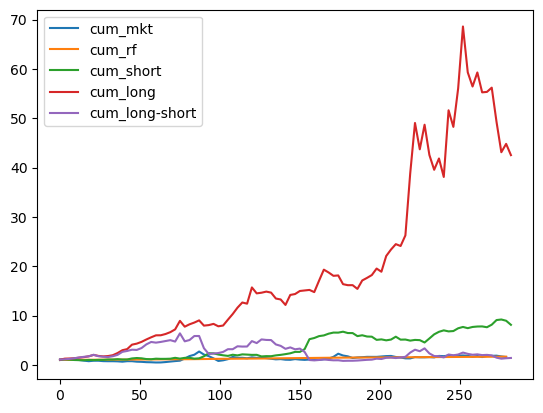

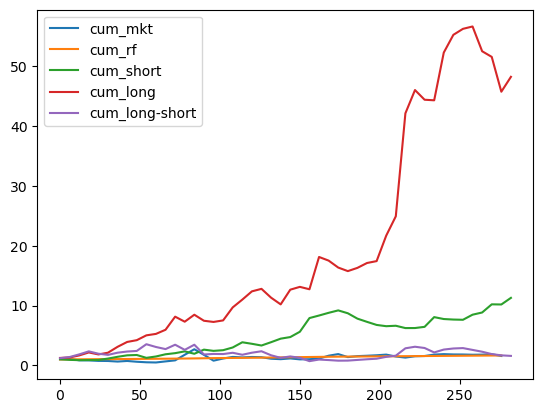

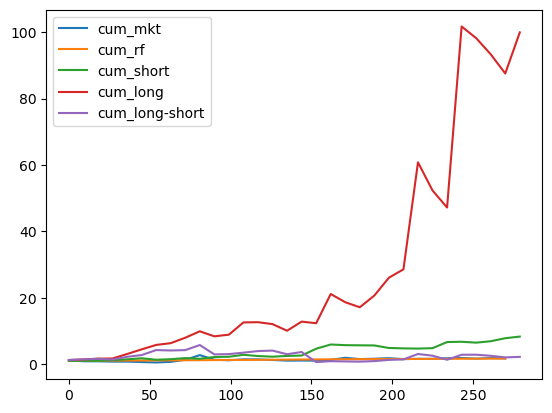

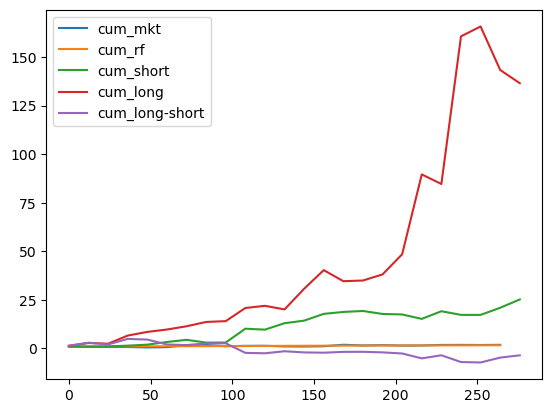

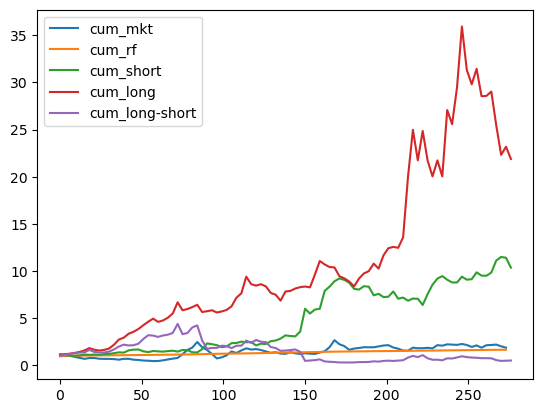

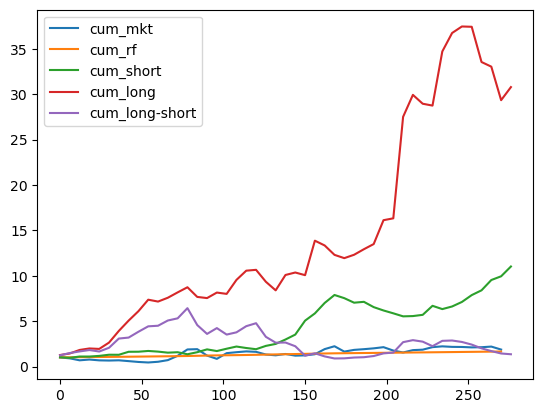

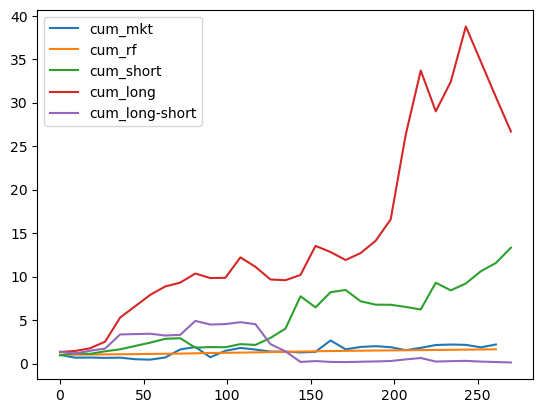

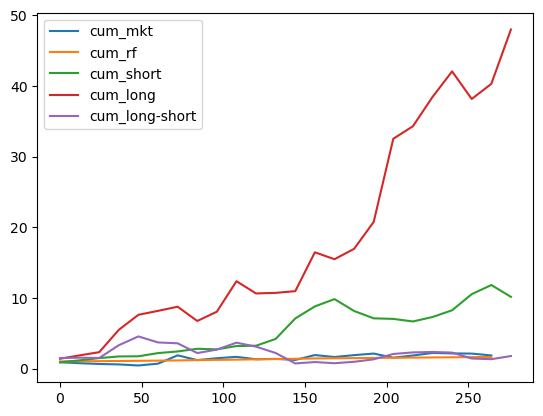

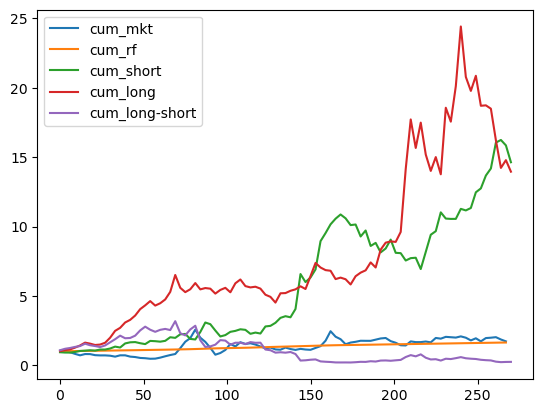

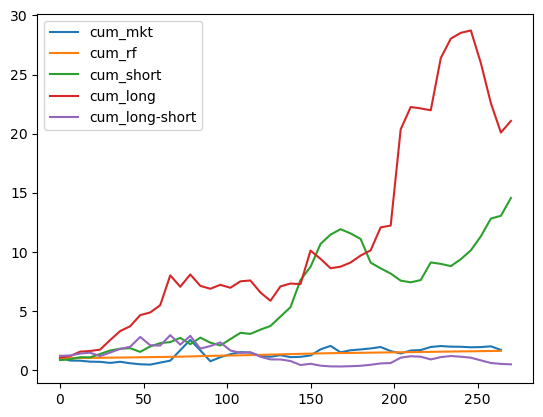

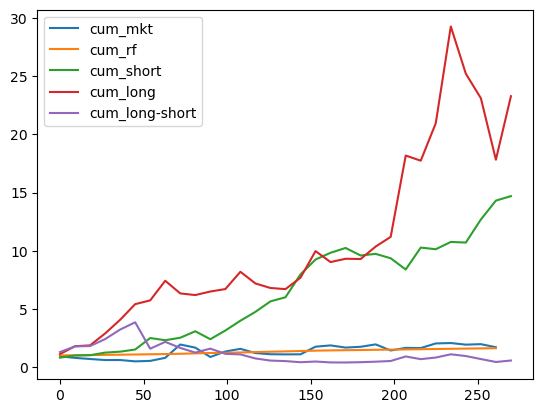

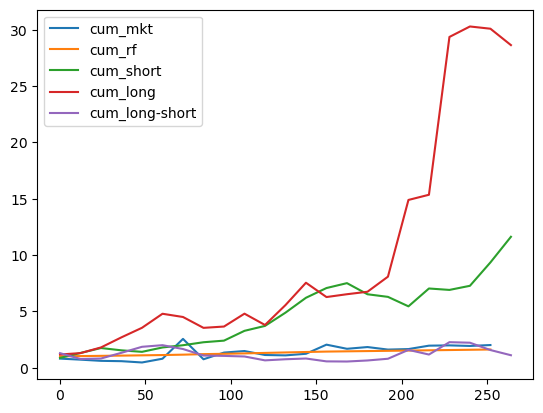

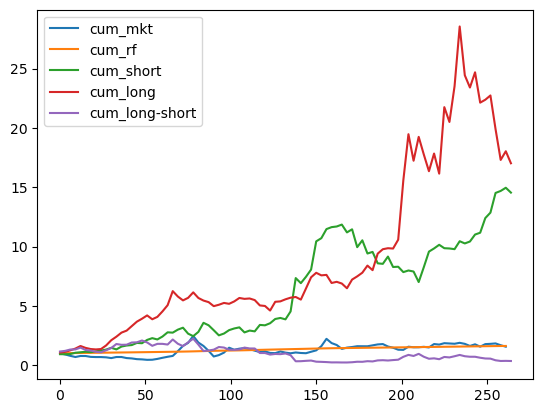

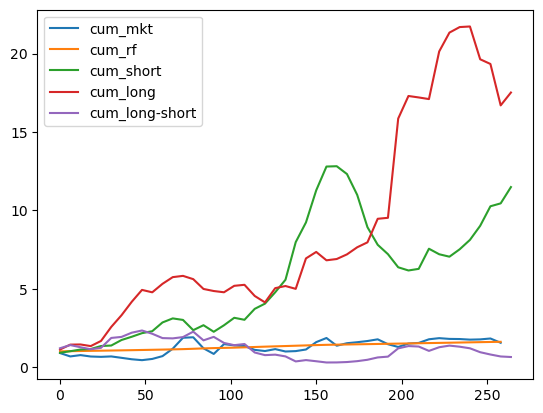

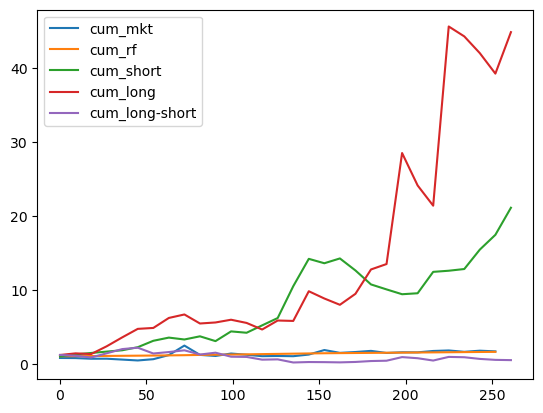

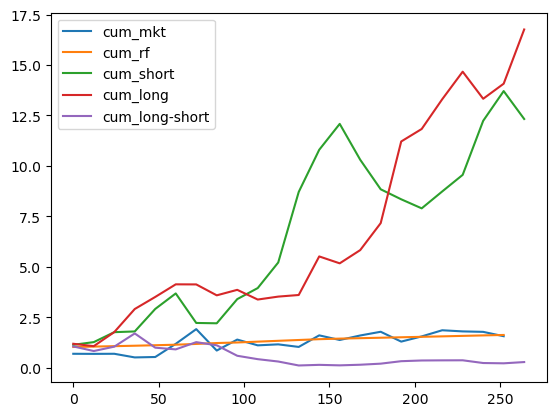

In [242]:
chart_vw_3for3 = get_backtest_chart(vw_3for3, 3)
chart_vw_3for3.figure.savefig('output/part3/7. backtest_vw_3for3.png')
chart_vw_3for6 = get_backtest_chart(vw_3for6, 6)
chart_vw_3for6.figure.savefig('output/part3/7. backtest_vw_3for6.png')
chart_vw_3for9 = get_backtest_chart(vw_3for9, 9)
chart_vw_3for9.figure.savefig('output/part3/7. backtest_vw_3for9.png')
chart_vw_3for12 = get_backtest_chart(vw_3for12, 12)
chart_vw_3for12.figure.savefig('output/part3/7. backtest_vw_3for12.png')
chart_vw_6for3 = get_backtest_chart(vw_6for3, 3)
chart_vw_6for3.figure.savefig('output/part3/7. backtest_vw_6for3.png')
chart_vw_6for6 = get_backtest_chart(vw_6for6, 6)
chart_vw_6for6.figure.savefig('output/part3/7. backtest_vw_6for6.png')
chart_vw_6for9 = get_backtest_chart(vw_6for9, 9)
chart_vw_6for9.figure.savefig('output/part3/7. backtest_vw_6for9.png')
chart_vw_6for12 = get_backtest_chart(vw_6for12, 12)
chart_vw_6for12.figure.savefig('output/part3/7. backtest_vw_6for12.png')
chart_vw_9for3 = get_backtest_chart(vw_9for3, 3)
chart_vw_9for3.figure.savefig('output/part3/7. backtest_vw_9for3.png')
chart_vw_9for6 = get_backtest_chart(vw_9for6, 6)
chart_vw_9for6.figure.savefig('output/part3/7. backtest_vw_9for6.png')
chart_vw_9for9 = get_backtest_chart(vw_9for9, 9)
chart_vw_9for9.figure.savefig('output/part3/7. backtest_vw_9for9.png')
chart_vw_9for12 = get_backtest_chart(vw_9for12, 12)
chart_vw_9for12.figure.savefig('output/part3/7. backtest_vw_9for12.png')
chart_vw_12for3 = get_backtest_chart(vw_12for3, 3)
chart_vw_12for3.figure.savefig('output/part3/7. backtest_vw_12for3.png')
chart_vw_12for6 = get_backtest_chart(vw_12for6, 6)
chart_vw_12for6.figure.savefig('output/part3/7. backtest_vw_12for6.png')
chart_vw_12for9 = get_backtest_chart(vw_12for9, 9)
chart_vw_12for9.figure.savefig('output/part3/7. backtest_vw_12for9.png')
chart_vw_12for12 = get_backtest_chart(vw_12for12, 12)
chart_vw_12for12.figure.savefig('output/part3/7. backtest_vw_12for12.png')

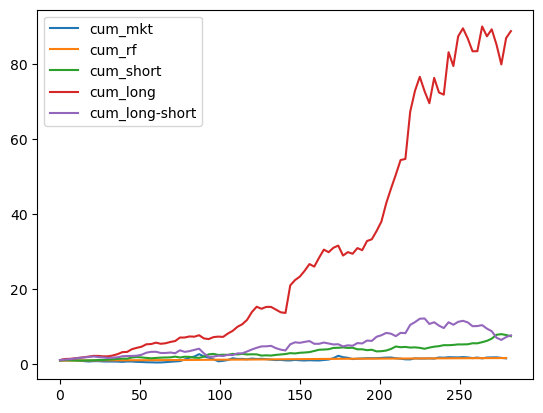

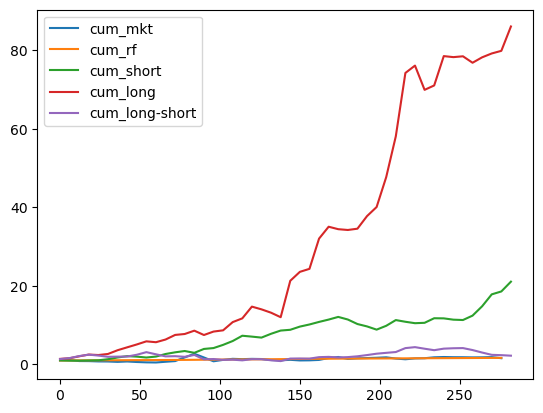

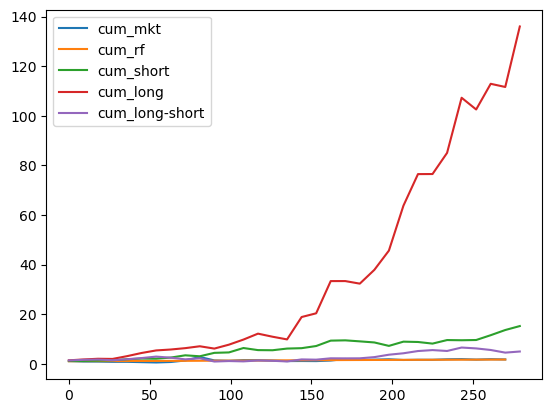

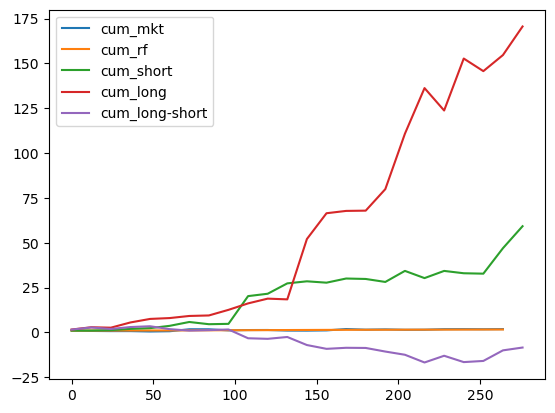

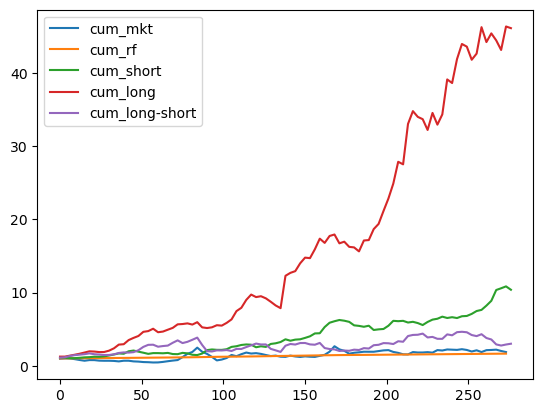

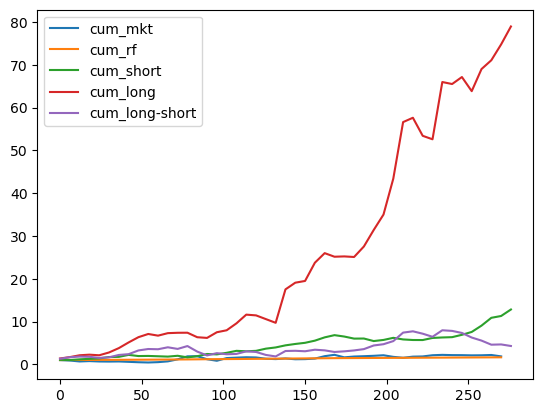

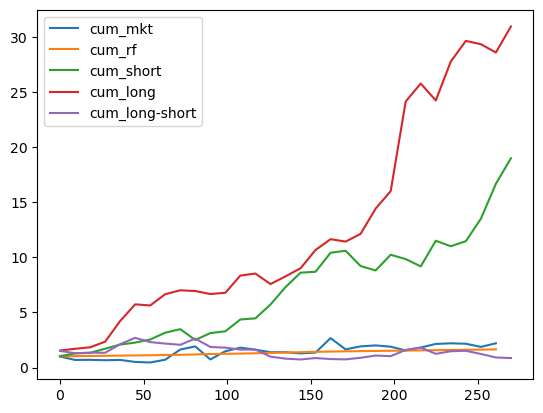

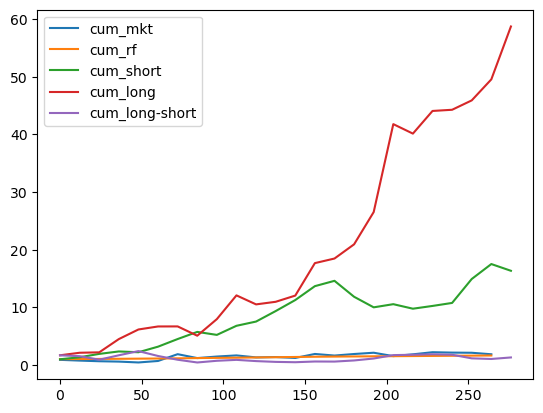

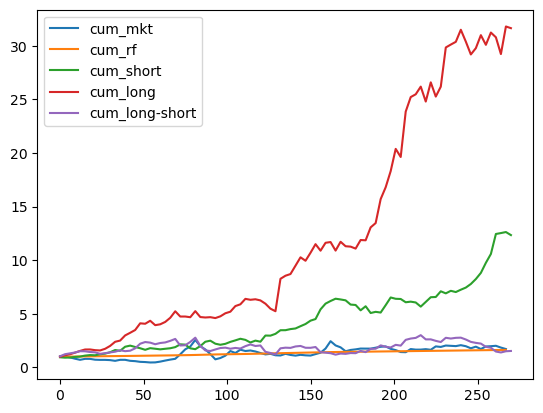

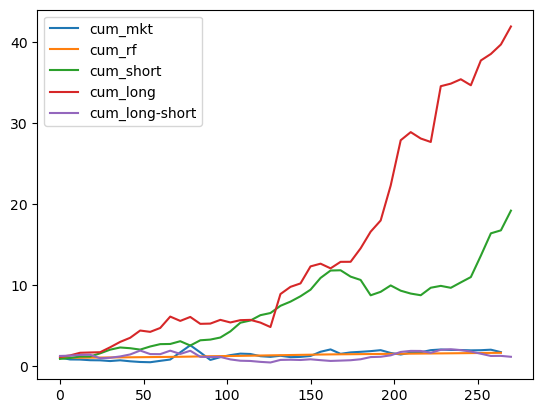

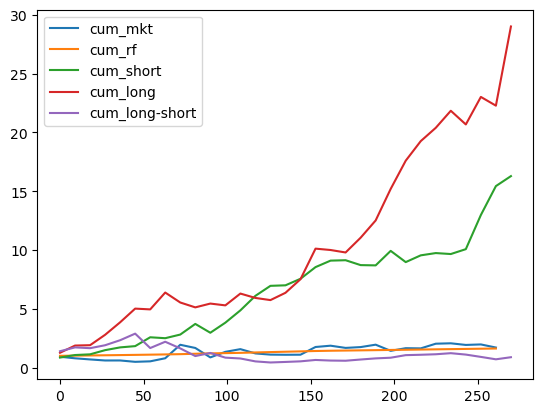

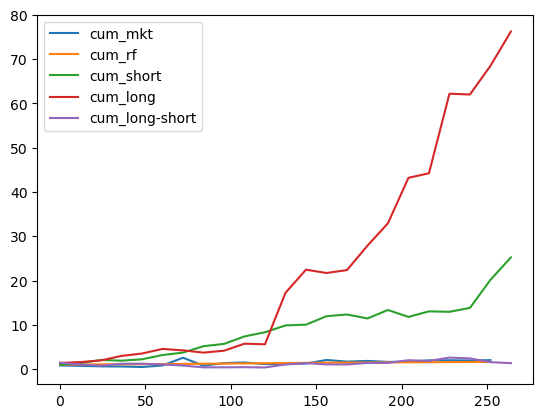

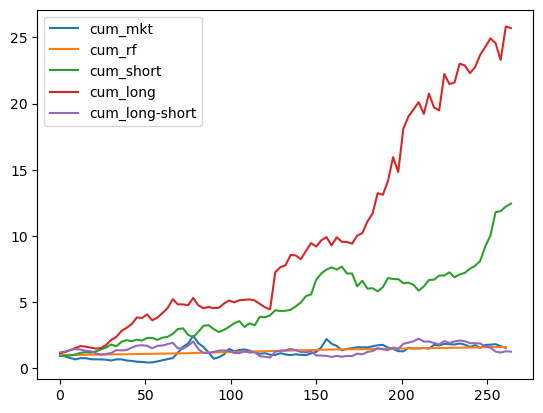

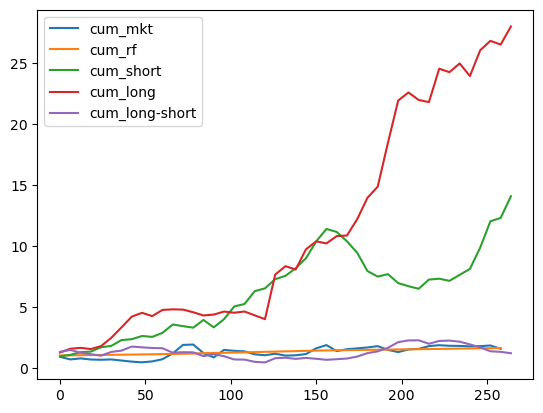

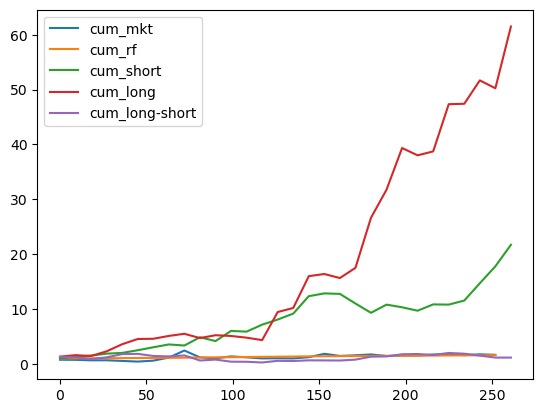

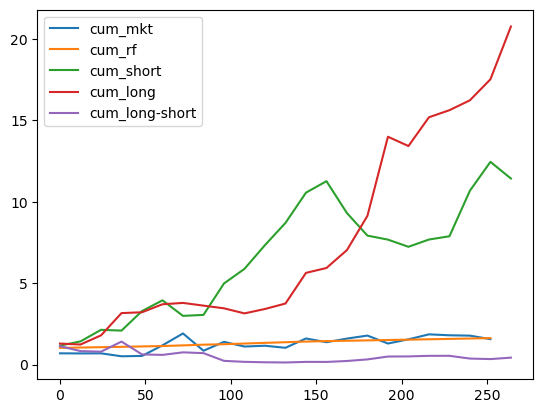

In [244]:
chart_ew_3for3 = get_backtest_chart(ew_3for3, 3)
chart_ew_3for3.figure.savefig('output/part3/7. backtest_ew_3for3.png')
chart_ew_3for6 = get_backtest_chart(ew_3for6, 6)
chart_ew_3for6.figure.savefig('output/part3/7. backtest_ew_3for6.png')
chart_ew_3for9 = get_backtest_chart(ew_3for9, 9)
chart_ew_3for9.figure.savefig('output/part3/7. backtest_ew_3for9.png')
chart_ew_3for12 = get_backtest_chart(ew_3for12, 12)
chart_ew_3for12.figure.savefig('output/part3/7. backtest_ew_3for12.png')
chart_ew_6for3 = get_backtest_chart(ew_6for3, 3)
chart_ew_6for3.figure.savefig('output/part3/7. backtest_ew_6for3.png')
chart_ew_6for6 = get_backtest_chart(ew_6for6, 6)
chart_ew_6for6.figure.savefig('output/part3/7. backtest_ew_6for6.png')
chart_ew_6for9 = get_backtest_chart(ew_6for9, 9)
chart_ew_6for9.figure.savefig('output/part3/7. backtest_ew_6for9.png')
chart_ew_6for12 = get_backtest_chart(ew_6for12, 12)
chart_ew_6for12.figure.savefig('output/part3/7. backtest_ew_6for12.png')
chart_ew_9for3 = get_backtest_chart(ew_9for3, 3)
chart_ew_9for3.figure.savefig('output/part3/7. backtest_ew_9for3.png')
chart_ew_9for6 = get_backtest_chart(ew_9for6, 6)
chart_ew_9for6.figure.savefig('output/part3/7. backtest_ew_9for6.png')
chart_ew_9for9 = get_backtest_chart(ew_9for9, 9)
chart_ew_9for9.figure.savefig('output/part3/7. backtest_ew_9for9.png')
chart_ew_9for12 = get_backtest_chart(ew_9for12, 12)
chart_ew_9for12.figure.savefig('output/part3/7. backtest_ew_9for12.png')
chart_ew_12for3 = get_backtest_chart(ew_12for3, 3)
chart_ew_12for3.figure.savefig('output/part3/7. backtest_ew_12for3.png')
chart_ew_12for6 = get_backtest_chart(ew_12for6, 6)
chart_ew_12for6.figure.savefig('output/part3/7. backtest_ew_12for6.png')
chart_ew_12for9 = get_backtest_chart(ew_12for9, 9)
chart_ew_12for9.figure.savefig('output/part3/7. backtest_ew_12for9.png')
chart_ew_12for12 = get_backtest_chart(ew_12for12, 12)
chart_ew_12for12.figure.savefig('output/part3/7. backtest_ew_12for12.png')